In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
import math
import random

from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import RNN, SimpleRNN, LSTM, GRU, BatchNormalization, Dense
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

random.seed(2)
np.random.seed(2)
tf.random.set_seed(2)

2024-07-16 03:50:02.897739: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-16 03:50:03.038470: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-07-16 03:50:03.038497: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-07-16 03:50:03.068747: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-16 03:50:03.867420: W tensorflow/stream_executor/pla

In [ ]:
daily_gold = pd.read_csv("/work/Daily/Commodities/Daily_XAU_USD_01-12-2014_01-12-2024.csv")
daily_oil = pd.read_csv("/work/Daily/Commodities/Daily_Crude Oil_01-12-2014_01-12-2024.csv")

daily_barrick = pd.read_csv("/work/Daily/Stock/Daily_BARRICK_01-12-2014_01-12-2024.csv")
daily_newmont = pd.read_csv("/work/Daily/Stock/Daily_NEWMONT_01-12-2014_01-12-2024.csv")
daily_chevron = pd.read_csv("/work/Daily/Stock/Daily_CHEVRON_01-12-2014_01-12-2024.csv")
daily_exxon = pd.read_csv("/work/Daily/Stock/Daily_EXXON_01-12-2014_01-12-2024.csv")

weekly_gold = pd.read_csv("/work/Weekly/Commodities/Weekly_XAU_USD_01-12-2014_01-12-2024.csv")
weekly_oil = pd.read_csv("/work/Weekly/Commodities/Weekly_Crude Oil_01-12-2014_01-12-2024.csv")

weekly_barrick = pd.read_csv("/work/Weekly/Stock/Weekly_BARRICK_01-12-2014_01-12-2024.csv")
weekly_newmont = pd.read_csv("/work/Weekly/Stock/Weekly_NEWMONT_01-12-2014_01-12-2024.csv")
weekly_chevron = pd.read_csv("/work/Weekly/Stock/Weekly_CHEVRON_01-12-2014_01-12-2024.csv")
weekly_exxon = pd.read_csv("/work/Weekly/Stock/Weekly_EXXON_01-12-2014_01-12-2024.csv")

daily_gold = daily_gold.drop("Vol.", axis=1)
daily_oil = daily_oil.drop("Vol.", axis=1)

daily_barrick = daily_barrick.drop("Vol.", axis=1)
daily_newmont = daily_newmont.drop("Vol.", axis=1)
daily_chevron = daily_chevron.drop("Vol.", axis=1)
daily_exxon = daily_exxon.drop("Vol.", axis=1)

weekly_gold = weekly_gold.drop("Vol.", axis=1)
weekly_oil = weekly_oil.drop("Vol.", axis=1)

weekly_barrick = weekly_barrick.drop("Vol.", axis=1)
weekly_newmont = weekly_newmont.drop("Vol.", axis=1)
weekly_chevron = weekly_chevron.drop("Vol.", axis=1)
weekly_exxon = weekly_exxon.drop("Vol.", axis=1)

daily_gold.iloc[:, 1:] = daily_gold.iloc[:, 1:].replace({',': '', '%': ''}, regex=True).astype(float)
daily_oil.iloc[:, 1:] = daily_oil.iloc[:, 1:].replace({',': '', '%': ''}, regex=True).astype(float)

daily_barrick.iloc[:, 1:] = daily_barrick.iloc[:, 1:].replace({',': '', '%': ''}, regex=True).astype(float)
daily_newmont.iloc[:, 1:] = daily_newmont.iloc[:, 1:].replace({',': '', '%': ''}, regex=True).astype(float)
daily_chevron.iloc[:, 1:] = daily_chevron.iloc[:, 1:].replace({',': '', '%': ''}, regex=True).astype(float)
daily_exxon.iloc[:, 1:] = daily_exxon.iloc[:, 1:].replace({',': '', '%': ''}, regex=True).astype(float)

weekly_gold.iloc[:, 1:] = weekly_barrick.iloc[:, 1:].replace({',': '', '%': '', 'M':''}, regex=True).astype(float)
weekly_oil.iloc[:, 1:] = weekly_newmont.iloc[:, 1:].replace({',': '', '%': '', 'M':''}, regex=True).astype(float)

weekly_barrick.iloc[:, 1:] = weekly_barrick.iloc[:, 1:].replace({',': '', '%': '', 'M':''}, regex=True).astype(float)
weekly_newmont.iloc[:, 1:] = weekly_newmont.iloc[:, 1:].replace({',': '', '%': '', 'M':''}, regex=True).astype(float)
weekly_chevron.iloc[:, 1:] = weekly_chevron.iloc[:, 1:].replace({',': '', '%': '', 'M':''}, regex=True).astype(float)
weekly_exxon.iloc[:, 1:] = weekly_exxon.iloc[:, 1:].replace({',': '', '%': '', 'M':''}, regex=True).astype(float)

daily_gold.iloc[:, -1] *= 0.01
daily_oil.iloc[:, -1] *= 0.01
daily_barrick.iloc[:, -1] *= 0.01
daily_newmont.iloc[:, -1] *= 0.01
daily_chevron.iloc[:, -1] *= 0.01
daily_exxon.iloc[:, -1] *= 0.01

weekly_gold.iloc[:, -1] *= 0.01
weekly_oil.iloc[:, -1] *= 0.01
weekly_barrick.iloc[:, -1] *= 0.01
weekly_newmont.iloc[:, -1] *= 0.01
weekly_chevron.iloc[:, -1] *= 0.01
weekly_exxon.iloc[:, -1] *= 0.01

daily_gold['Date'] = pd.to_datetime(daily_gold['Date'], format='%m/%d/%Y', errors='coerce')
daily_oil['Date'] = pd.to_datetime(daily_oil['Date'], format='%m/%d/%Y', errors='coerce')

daily_barrick['Date'] = pd.to_datetime(daily_barrick['Date'], format='%m/%d/%Y', errors='coerce')
daily_newmont['Date'] = pd.to_datetime(daily_newmont['Date'], format='%m/%d/%Y', errors='coerce')
daily_chevron['Date'] = pd.to_datetime(daily_chevron['Date'], format='%m/%d/%Y', errors='coerce')
daily_exxon['Date'] = pd.to_datetime(daily_exxon['Date'], format='%m/%d/%Y', errors='coerce')

weekly_gold['Date'] = pd.to_datetime(weekly_gold['Date'], format='%m/%d/%Y', errors='coerce')
weekly_oil['Date'] = pd.to_datetime(weekly_oil['Date'], format='%m/%d/%Y', errors='coerce')

weekly_barrick['Date'] = pd.to_datetime(weekly_barrick['Date'], format='%m/%d/%Y', errors='coerce')
weekly_newmont['Date'] = pd.to_datetime(weekly_newmont['Date'], format='%m/%d/%Y', errors='coerce')
weekly_chevron['Date'] = pd.to_datetime(weekly_chevron['Date'], format='%m/%d/%Y', errors='coerce')
weekly_exxon['Date'] = pd.to_datetime(weekly_exxon['Date'], format='%m/%d/%Y', errors='coerce')

daily_gold.set_index('Date', inplace=True)
daily_oil.set_index('Date', inplace=True)

daily_barrick.set_index('Date', inplace=True)
daily_newmont.set_index('Date', inplace=True)
daily_chevron.set_index('Date', inplace=True)
daily_exxon.set_index('Date', inplace=True)

weekly_gold.set_index('Date', inplace=True)
weekly_oil.set_index('Date', inplace=True)

weekly_barrick.set_index('Date', inplace=True)
weekly_newmont.set_index('Date', inplace=True)
weekly_chevron.set_index('Date', inplace=True)
weekly_exxon.set_index('Date', inplace=True)

In [ ]:
master_daily = daily_gold.add_suffix('_gold')

dfs = [daily_oil, daily_barrick, daily_newmont, daily_exxon, daily_chevron]

suffixes = ['_oil', '_barrick', '_newmont', '_exxon', '_chevron']

suffix_dfs = []

for i in range(len(dfs)):
    suffix_dfs.append(dfs[i].add_suffix(suffixes[i]))

for i in range(len(dfs)):
    master_daily = master_daily.join(suffix_dfs[i])

master_daily = master_daily.dropna()

master_daily

,Price_gold,Open_gold,High_gold,Low_gold,Change %_gold,Price_oil,Open_oil,High_oil,Low_oil,Change %_oil,...,Price_exxon,Open_exxon,High_exxon,Low_exxon,Change %_exxon,Price_chevron,Open_chevron,High_chevron,Low_chevron,Change %_chevron
Date,,,,,,,,,,,,,,,,,,,,,
2024-01-11,2028.09,2023.74,2039.69,2013.32,0.0023,72.02,71.33,73.81,71.17,0.0091,...,98.67,99.04,99.50,98.56,-0.0002,145.28,145.56,146.17,144.62,0.0054
2024-01-10,2023.4,2029.94,2040.44,2020.45,-0.0031,71.37,72.17,73.59,71.01,-0.012,...,98.69,99.80,99.80,98.16,-0.0098,144.50,146.02,146.02,144.11,-0.0082
2024-01-09,2029.59,2028.4,2042.09,2026.11,0.0009,72.24,70.91,72.93,70.47,0.0208,...,99.67,101.29,101.29,99.19,-0.0124,145.70,149.95,149.95,145.59,-0.0254
2024-01-08,2027.84,2044.08,2046.71,2016.84,-0.0086,70.77,73.51,73.95,70.13,-0.0412,...,100.92,100.73,101.04,98.90,-0.0167,149.50,148.42,149.70,146.58,-0.006
2024-01-05,2045.5,2043.69,2064.03,2024.49,0.0011,73.81,72.40,74.24,72.21,0.0224,...,102.63,103.17,103.40,102.13,0.003,150.40,151.98,152.03,149.83,-0.0017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-01-17,1253.82,1242.53,1255.28,1238.05,0.0091,94.37,94.17,94.94,93.94,0.0044,...,99.16,99.18,100.34,98.67,0.0022,119.29,119.03,120.38,118.74,0.0039
2014-01-16,1242.55,1241.49,1245.26,1236.55,0.0007,93.96,94.29,94.64,93.60,-0.0022,...,98.94,98.79,99.04,98.25,0.0016,118.83,119.11,119.29,118.19,-0.0029
2014-01-15,1241.74,1245.1,1245.39,1234.49,-0.0027,94.17,92.65,94.64,92.43,0.0171,...,98.78,99.16,99.35,98.63,-0.0034,119.18,119.69,120.07,119.05,-0.0033


### GRU

#### Gold

In [ ]:
# Setting Up
# Define your features (dependent variables) and target (independent variable)
features = ['Open', 'High', 'Low', 'Change %']
target = 'Price'

# Normalize the data
scaler = MinMaxScaler()
daily_gold_scaled = pd.DataFrame()
daily_gold_scaled[['Open', 'High', 'Low', 'Change %','Price']] = scaler.fit_transform(daily_gold[['Open', 'High', 'Low', 'Change %','Price']])
daily_gold_time = daily_gold.index
daily_gold_scaled.set_index(daily_gold_time,inplace = True)
daily_gold_scaled = daily_gold_scaled[::-1]

window_size = 5

# Function to create input data sequences and labels
def create_sequences(data, window_size):
    X = []
    y = []
    for i in range(len(data) - window_size):
        X.append(data[features][i:i+window_size].values)
        y.append([data[target][i+window_size]])
    return np.array(X), np.array(y)

# Create sequences and labels
X_gold, y_gold = create_sequences(daily_gold_scaled, window_size)

y_gold = pd.DataFrame(y_gold).set_index(daily_gold_scaled.index[window_size:len(daily_gold_scaled)])

# Split the data into training and testing sets
X_train_gold, X_test_gold, y_train_gold, y_test_gold = train_test_split(X_gold, y_gold, test_size=0.2, shuffle=False)



#Oil
# Normalize the data
daily_oil_scaled = pd.DataFrame()
daily_oil_scaled[['Open', 'High', 'Low', 'Change %','Price']] = scaler.fit_transform(daily_oil[['Open', 'High', 'Low', 'Change %','Price']])
daily_oil_time = daily_oil.index
daily_oil_scaled.set_index(daily_oil_time,inplace = True)
daily_oil_scaled = daily_oil_scaled[::-1]

# Create sequences and labels
X_oil, y_oil = create_sequences(daily_oil_scaled, window_size)

y_oil = pd.DataFrame(y_oil).set_index(daily_oil_scaled.index[window_size:len(daily_oil_scaled)])

# Split the data into training and testing sets
X_train_oil, X_test_oil, y_train_oil, y_test_oil = train_test_split(X_oil, y_oil, test_size=0.2, shuffle=False)


# Function to inverse scaling
def inverse_minmax_scaling(scaled_data, min_val, max_val):
    original_data = scaled_data * (max_val - min_val) + min_val
    return original_data

# Inverse scale actual data
y_train_gold_true = pd.DataFrame(inverse_minmax_scaling(y_train_gold, min(daily_gold['Price']), max(daily_gold['Price'])))
y_test_gold_true = pd.DataFrame(inverse_minmax_scaling(y_test_gold, min(daily_gold['Price']), max(daily_gold['Price'])))


  y.append([data[target][i+window_size]])
/tmp/ipykernel_86/529283289.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append([data[target][i+window_size]])
/tmp/ipykernel_86/529283289.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append([data[target][i+window_size]])
/tmp/ipykernel_86/529283289.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append([data[target][i+window_size]])
/tmp/ipykernel_86/529283289.py:

In [ ]:
# Creating the dataframe and X,y values for Barrick
daily_barrick_scaled = pd.DataFrame()
daily_barrick_scaled[['Open', 'High', 'Low', 'Change %','Price']] = scaler.fit_transform(daily_barrick[['Open', 'High', 'Low', 'Change %','Price']])
daily_barrick_time = daily_barrick.index
daily_barrick_scaled.set_index(daily_barrick_time,inplace = True)
daily_barrick_scaled = daily_barrick_scaled[::-1]

X_barrick, y_barrick = create_sequences(daily_barrick_scaled, window_size)
y_barrick = pd.DataFrame(y_barrick).set_index(daily_barrick_scaled.index[window_size:len(daily_barrick_scaled)])


# Creating the dataframe and X,y values for Newmont
daily_newmont_scaled = pd.DataFrame()
daily_newmont_scaled[['Open', 'High', 'Low', 'Change %','Price']] = scaler.fit_transform(daily_newmont[['Open', 'High', 'Low', 'Change %','Price']])
daily_newmont_time = daily_newmont.index
daily_newmont_scaled.set_index(daily_newmont_time,inplace = True)
daily_newmont_scaled = daily_newmont_scaled[::-1]

X_newmont, y_newmont = create_sequences(daily_newmont_scaled, window_size)
y_newmont = pd.DataFrame(y_newmont).set_index(daily_newmont_scaled.index[window_size:len(daily_newmont_scaled)])


# Creating the dataframe and X,y values for Chevron
daily_chevron_scaled = pd.DataFrame()
daily_chevron_scaled[['Open', 'High', 'Low', 'Change %','Price']] = scaler.fit_transform(daily_chevron[['Open', 'High', 'Low', 'Change %','Price']])
daily_chevron_time = daily_chevron.index
daily_chevron_scaled.set_index(daily_chevron_time,inplace = True)
daily_chevron_scaled = daily_chevron_scaled[::-1]

X_chevron, y_chevron = create_sequences(daily_chevron_scaled, window_size)
y_chevron = pd.DataFrame(y_chevron).set_index(daily_chevron_scaled.index[window_size:len(daily_chevron_scaled)])


# Creating the dataframe and X,y values for Exxon
daily_exxon_scaled = pd.DataFrame()
daily_exxon_scaled[['Open', 'High', 'Low', 'Change %','Price']] = scaler.fit_transform(daily_exxon[['Open', 'High', 'Low', 'Change %','Price']])
daily_exxon_time = daily_exxon.index
daily_exxon_scaled.set_index(daily_exxon_time,inplace = True)
daily_exxon_scaled = daily_exxon_scaled[::-1]

X_exxon, y_exxon = create_sequences(daily_exxon_scaled, window_size)
y_exxon = pd.DataFrame(y_exxon).set_index(daily_exxon_scaled.index[window_size:len(daily_exxon_scaled)])

  y.append([data[target][i+window_size]])
/tmp/ipykernel_86/529283289.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append([data[target][i+window_size]])
/tmp/ipykernel_86/529283289.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append([data[target][i+window_size]])
/tmp/ipykernel_86/529283289.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append([data[target][i+window_size]])
/tmp/ipykernel_86/529283289.py:

In [ ]:
y_barrick_true = pd.DataFrame(inverse_minmax_scaling(y_barrick, min(daily_barrick['Price']), max(daily_barrick['Price'])))
y_newmont_true = pd.DataFrame(inverse_minmax_scaling(y_newmont, min(daily_newmont['Price']), max(daily_newmont['Price'])))
y_chevron_true = pd.DataFrame(inverse_minmax_scaling(y_chevron, min(daily_chevron['Price']), max(daily_chevron['Price'])))
y_exxon_true = pd.DataFrame(inverse_minmax_scaling(y_exxon, min(daily_exxon['Price']), max(daily_exxon['Price'])))

### Test 1 More Neurons 512 > 128 > 32 > 8

In [ ]:
# Define the model
model_GRU_Gold = Sequential([
    GRU(512, activation = 'relu', return_sequences=True, input_shape=(window_size, len(features))),
    GRU(128, activation = 'relu', return_sequences=True),
    GRU(32, activation = 'relu', return_sequences=True),
    GRU(8, activation = 'relu'),
    Dense(1)
])

# Compile the model
model_GRU_Gold.compile(optimizer='adam', loss='mse')

# Train the model
model_GRU_Gold.fit(X_train_gold, y_train_gold, epochs=50, batch_size=32, validation_split=0.2)

# Evaluate the model
loss_GRU_Gold_train = model_GRU_Gold.evaluate(X_train_gold, y_train_gold)
loss_GRU_Gold_test = model_GRU_Gold.evaluate(X_test_gold, y_test_gold)
print("Train Loss:", loss_GRU_Gold_train)
print("Test Loss:", loss_GRU_Gold_test)

#Predict
pred_gold_train_GRU = model_GRU_Gold.predict(X_train_gold)
pred_gold_train_GRU = pred_gold_train_GRU.reshape(len(pred_gold_train_GRU))

pred_gold_test_GRU = model_GRU_Gold.predict(X_test_gold)
pred_gold_test_GRU = pred_gold_test_GRU.reshape(len(pred_gold_test_GRU))

2024-07-16 03:50:19.513006: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2024-07-16 03:50:19.514523: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2024-07-16 03:50:19.514562: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (p-37cc49da-a460-4de1-b51b-4428efcf8114): /proc/driver/nvidia/version does not exist
2024-07-16 03:50:19.517885: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
Epoch 1/50
52/52 [==============================] - 8s 91ms/step - loss: 0.0

#### Predict Gold Stock Price

In [ ]:
# Create the predictions Barrick
pred_barrick_GRU = model_GRU_Gold.predict(X_barrick)
pred_barrick_GRU = pred_barrick_GRU.reshape(len(pred_barrick_GRU))

pred_barrick_GRU_true = pd.DataFrame(inverse_minmax_scaling(pred_barrick_GRU, min(daily_barrick['Price']), max(daily_barrick['Price'])))

pred_barrick_GRU_true.set_index(y_barrick_true.index, inplace = True)

79/79 [==============================] - 1s 17ms/step


In [ ]:
# Create the predictions Newmont
pred_newmont_GRU = model_GRU_Gold.predict(X_newmont)
pred_newmont_GRU = pred_newmont_GRU.reshape(len(pred_newmont_GRU))

pred_newmont_GRU_true = pd.DataFrame(inverse_minmax_scaling(pred_newmont_GRU, min(daily_newmont['Price']), max(daily_newmont['Price'])))

pred_newmont_GRU_true.set_index(y_newmont_true.index, inplace = True)

79/79 [==============================] - 1s 16ms/step


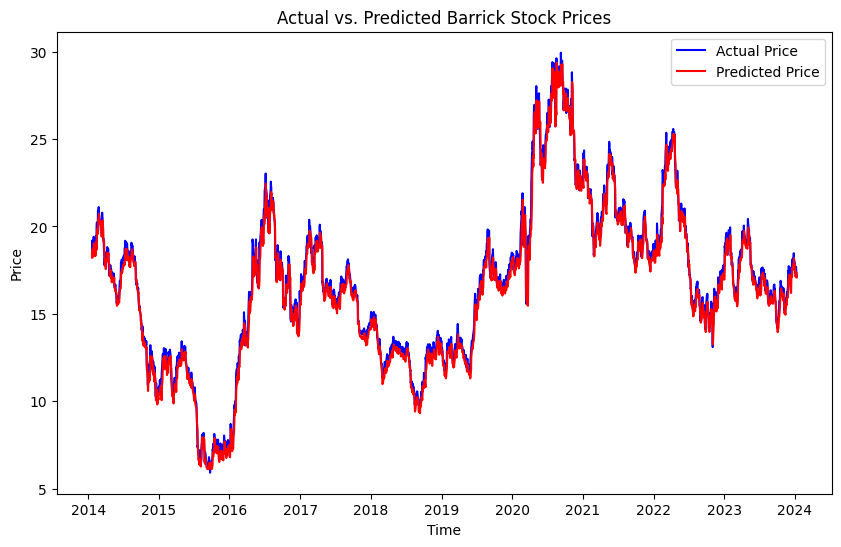

Mean Squared Error of True Data (RMSE): 0.28346160314424407
Mean Squared Error of Scaled Data(RMSE): 0.0004908929715997339


In [ ]:
# Plotting the actual vs. predicted barrick stock prices
plt.figure(figsize=(10, 6))
plt.plot(y_barrick_true, label='Actual Price', color='blue')
plt.plot(pred_barrick_GRU_true, label='Predicted Price', color='red')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Actual vs. Predicted Barrick Stock Prices')
plt.legend()
plt.show()

print("Mean Squared Error of True Data (RMSE):", mean_squared_error(y_barrick_true, pred_barrick_GRU_true))
print("Mean Squared Error of Scaled Data(RMSE):", mean_squared_error(y_barrick, pred_barrick_GRU))

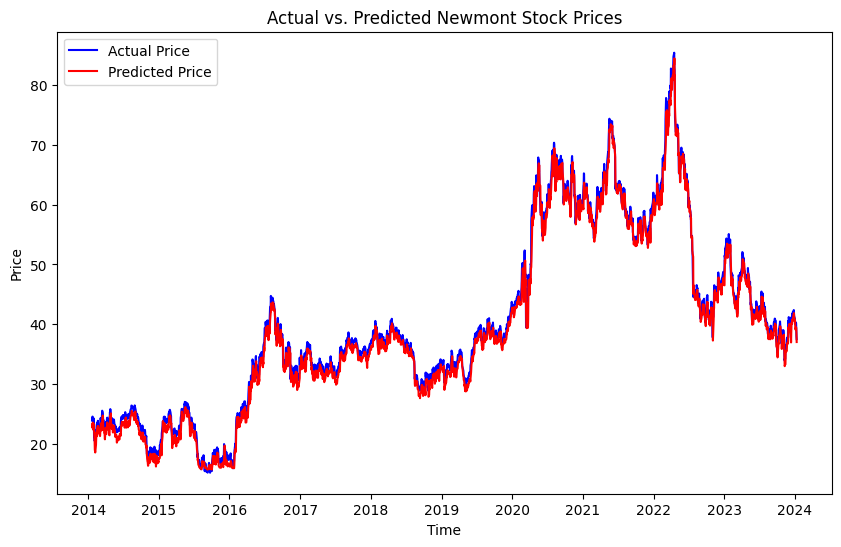

Mean Squared Error of True Data (RMSE): 1.8001518232106897
Mean Squared Error (RMSE): 0.0003647677541271519


In [ ]:
# Plotting the actual vs. predicted newmont stock prices
plt.figure(figsize=(10, 6))
plt.plot(y_newmont_true, label='Actual Price', color='blue')
plt.plot(pred_newmont_GRU_true, label='Predicted Price', color='red')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Actual vs. Predicted Newmont Stock Prices')
plt.legend()
plt.show()

print("Mean Squared Error of True Data (RMSE):", mean_squared_error(y_newmont_true, pred_newmont_GRU_true))
print("Mean Squared Error (RMSE):", mean_squared_error(y_newmont, pred_newmont_GRU))

#### Oil

In [ ]:
#Oil

# Define the model
model_GRU_Oil = Sequential([
    GRU(512, activation = 'relu', return_sequences=True, input_shape=(window_size, len(features))),
    GRU(128, activation = 'relu', return_sequences=True),
    GRU(32, activation = 'relu', return_sequences=True),
    GRU(8,  activation = 'relu'),
    Dense(1)
])

# Compile the model
model_GRU_Oil.compile(optimizer='adam', loss='mse')

# Train the model
model_GRU_Oil.fit(X_train_oil, y_train_oil, epochs=50, batch_size=32, validation_split=0.2)

# Evaluate the model
loss_GRU_Oil_train = model_GRU_Oil.evaluate(X_train_oil, y_train_oil)
loss_GRU_Oil_test = model_GRU_Oil.evaluate(X_test_oil, y_test_oil)
print("Train Loss:", loss_GRU_Oil_train)
print("Test Loss:", loss_GRU_Oil_test)

#Predict
pred_oil_train_GRU = model_GRU_Oil.predict(X_train_oil)
pred_oil_train_GRU = pred_oil_train_GRU.reshape(len(pred_oil_train_GRU))

pred_oil_test_GRU = model_GRU_Oil.predict(X_test_oil)
pred_oil_test_GRU = pred_oil_test_GRU.reshape(len(pred_oil_test_GRU))

Epoch 1/50
63/63 [==============================] - 10s 95ms/step - loss: 0.2652 - val_loss: 0.0018
Epoch 2/50
63/63 [==============================] - 5s 84ms/step - loss: 0.0013 - val_loss: 6.5226e-04
Epoch 3/50
63/63 [==============================] - 5s 83ms/step - loss: 1.9705e-04 - val_loss: 6.5237e-04
Epoch 4/50
63/63 [==============================] - 5s 84ms/step - loss: 1.8688e-04 - val_loss: 6.3400e-04
Epoch 5/50
63/63 [==============================] - 5s 84ms/step - loss: 1.9223e-04 - val_loss: 6.2706e-04
Epoch 6/50
63/63 [==============================] - 5s 83ms/step - loss: 1.9167e-04 - val_loss: 6.2657e-04
Epoch 7/50
63/63 [==============================] - 5s 82ms/step - loss: 1.8815e-04 - val_loss: 6.1591e-04
Epoch 8/50
63/63 [==============================] - 5s 87ms/step - loss: 1.9108e-04 - val_loss: 6.1714e-04
Epoch 9/50
63/63 [==============================] - 5s 85ms/step - loss: 2.0495e-04 - val_loss: 6.1865e-04
Epoch 10/50
63/63 [=============================

#### Predict Oil Stock Price

In [ ]:
# Create the predictions
pred_chevron_GRU = model_GRU_Oil.predict(X_chevron)
pred_chevron_GRU = pred_chevron_GRU.reshape(len(pred_chevron_GRU))

pred_chevron_GRU_true = pd.DataFrame(inverse_minmax_scaling(pred_chevron_GRU, min(daily_chevron['Price']), max(daily_chevron['Price'])))

pred_chevron_GRU_true.set_index(y_chevron_true.index, inplace = True)

79/79 [==============================] - 1s 16ms/step


In [ ]:
# Create the predictions
pred_exxon_GRU = model_GRU_Oil.predict(X_exxon)
pred_exxon_GRU = pred_exxon_GRU.reshape(len(pred_exxon_GRU))

pred_exxon_GRU_true = pd.DataFrame(inverse_minmax_scaling(pred_exxon_GRU, min(daily_exxon['Price']), max(daily_exxon['Price'])))

pred_exxon_GRU_true.set_index(y_exxon_true.index, inplace = True)

79/79 [==============================] - 1s 17ms/step


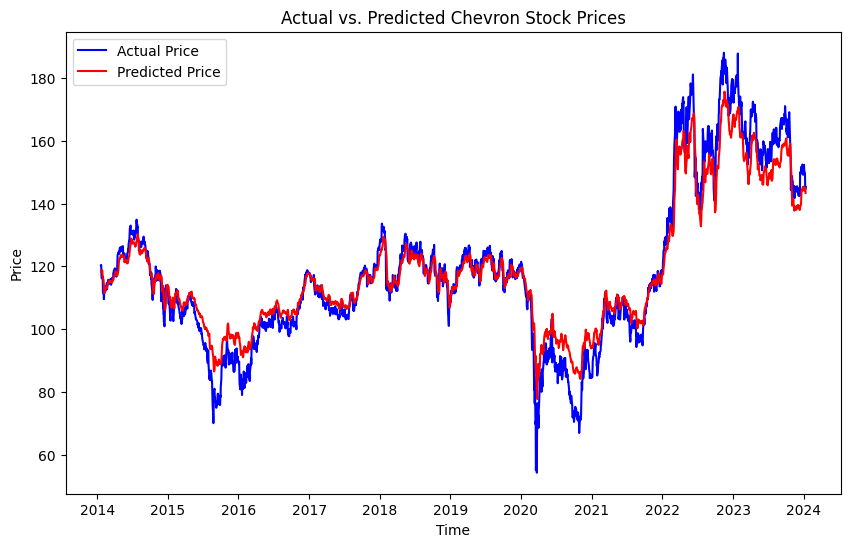

Mean Squared Error of True Data (RMSE): 38.53908799457159
Mean Squared Error of Scaled Data (RMSE): 0.002151763136547365


In [ ]:
# Plotting the actual vs. predicted chevron stock prices
plt.figure(figsize=(10, 6))
plt.plot(y_chevron_true, label='Actual Price', color='blue')
plt.plot(pred_chevron_GRU_true, label='Predicted Price', color='red')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Actual vs. Predicted Chevron Stock Prices')
plt.legend()
plt.show()

print("Mean Squared Error of True Data (RMSE):", mean_squared_error(y_chevron_true, pred_chevron_GRU_true))
print("Mean Squared Error of Scaled Data (RMSE):", mean_squared_error(y_chevron, pred_chevron_GRU))

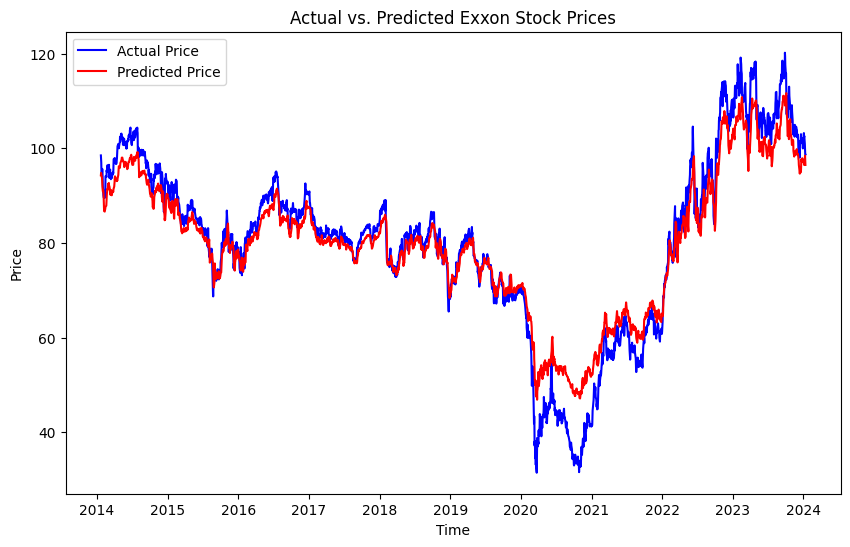

Mean Squared Error of True Data (RMSE): 24.0013535852993
Mean Squared Error of Scaled Data (RMSE): 0.0030471864954925883


In [ ]:
# Plotting the actual vs. predicted exxon stock prices
plt.figure(figsize=(10, 6))
plt.plot(y_exxon_true, label='Actual Price', color='blue')
plt.plot(pred_exxon_GRU_true, label='Predicted Price', color='red')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Actual vs. Predicted Exxon Stock Prices')
plt.legend()
plt.show()

print("Mean Squared Error of True Data (RMSE):",mean_squared_error(y_exxon_true, pred_exxon_GRU_true))
print("Mean Squared Error of Scaled Data (RMSE):", mean_squared_error(y_exxon, pred_exxon_GRU))

### Test 2 Less Neurons

In [ ]:
# Define the model
model_GRU_Gold = Sequential([
    GRU(32, activation = 'relu', return_sequences=True, input_shape=(window_size, len(features))),
    GRU(16, activation = 'relu', return_sequences=True),
    GRU(8, activation = 'relu', return_sequences=True),
    GRU(4, activation = 'relu'),
    Dense(1)
])

# Compile the model
model_GRU_Gold.compile(optimizer='adam', loss='mse')

# Train the model
model_GRU_Gold.fit(X_train_gold, y_train_gold, epochs=50, batch_size=32, validation_split=0.2)

# Evaluate the model
loss_GRU_Gold_train = model_GRU_Gold.evaluate(X_train_gold, y_train_gold)
loss_GRU_Gold_test = model_GRU_Gold.evaluate(X_test_gold, y_test_gold)
print("Train Loss:", loss_GRU_Gold_train)
print("Test Loss:", loss_GRU_Gold_test)

#Predict
pred_gold_train_GRU = model_GRU_Gold.predict(X_train_gold)
pred_gold_train_GRU = pred_gold_train_GRU.reshape(len(pred_gold_train_GRU))

pred_gold_test_GRU = model_GRU_Gold.predict(X_test_gold)
pred_gold_test_GRU = pred_gold_test_GRU.reshape(len(pred_gold_test_GRU))

Epoch 1/50
52/52 [==============================] - 4s 24ms/step - loss: 0.0350 - val_loss: 0.1534
Epoch 2/50
52/52 [==============================] - 1s 15ms/step - loss: 0.0060 - val_loss: 0.0012
Epoch 3/50
52/52 [==============================] - 1s 14ms/step - loss: 7.6339e-04 - val_loss: 0.0011
Epoch 4/50
52/52 [==============================] - 1s 13ms/step - loss: 5.6122e-04 - val_loss: 0.0010
Epoch 5/50
52/52 [==============================] - 1s 14ms/step - loss: 4.8775e-04 - val_loss: 0.0012
Epoch 6/50
52/52 [==============================] - 1s 14ms/step - loss: 4.4816e-04 - val_loss: 9.7853e-04
Epoch 7/50
52/52 [==============================] - 1s 14ms/step - loss: 4.2785e-04 - val_loss: 9.0808e-04
Epoch 8/50
52/52 [==============================] - 1s 13ms/step - loss: 4.0145e-04 - val_loss: 9.9174e-04
Epoch 9/50
52/52 [==============================] - 1s 14ms/step - loss: 3.7788e-04 - val_loss: 0.0011
Epoch 10/50
52/52 [==============================] - 1s 14ms/step - l

#### Predict Gold Stock Price

In [ ]:
# Create the predictions Barrick
pred_barrick_GRU = model_GRU_Gold.predict(X_barrick)
pred_barrick_GRU = pred_barrick_GRU.reshape(len(pred_barrick_GRU))

pred_barrick_GRU_true = pd.DataFrame(inverse_minmax_scaling(pred_barrick_GRU, min(daily_barrick['Price']), max(daily_barrick['Price'])))

pred_barrick_GRU_true.set_index(y_barrick_true.index, inplace = True)

# Create the predictions Newmont
pred_newmont_GRU = model_GRU_Gold.predict(X_newmont)
pred_newmont_GRU = pred_newmont_GRU.reshape(len(pred_newmont_GRU))

pred_newmont_GRU_true = pd.DataFrame(inverse_minmax_scaling(pred_newmont_GRU, min(daily_newmont['Price']), max(daily_newmont['Price'])))

pred_newmont_GRU_true.set_index(y_newmont_true.index, inplace = True)

79/79 [==============================] - 0s 5ms/step


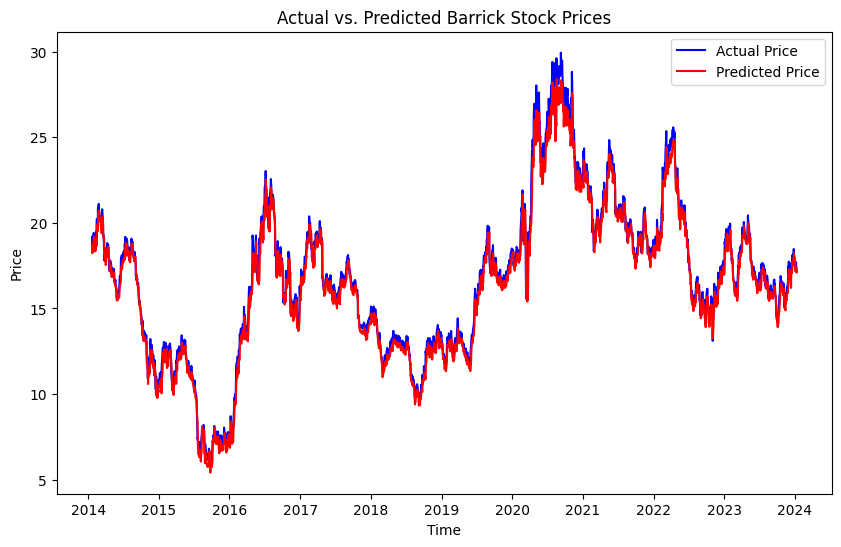

Mean Squared Error of True Data (RMSE): 0.3511638996770397
Mean Squared Error of Scaled Data(RMSE): 0.0006081384505938537


In [ ]:
# Plotting the actual vs. predicted barrick stock prices
plt.figure(figsize=(10, 6))
plt.plot(y_barrick_true, label='Actual Price', color='blue')
plt.plot(pred_barrick_GRU_true, label='Predicted Price', color='red')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Actual vs. Predicted Barrick Stock Prices')
plt.legend()
plt.show()

print("Mean Squared Error of True Data (RMSE):", mean_squared_error(y_barrick_true, pred_barrick_GRU_true))
print("Mean Squared Error of Scaled Data(RMSE):", mean_squared_error(y_barrick, pred_barrick_GRU))

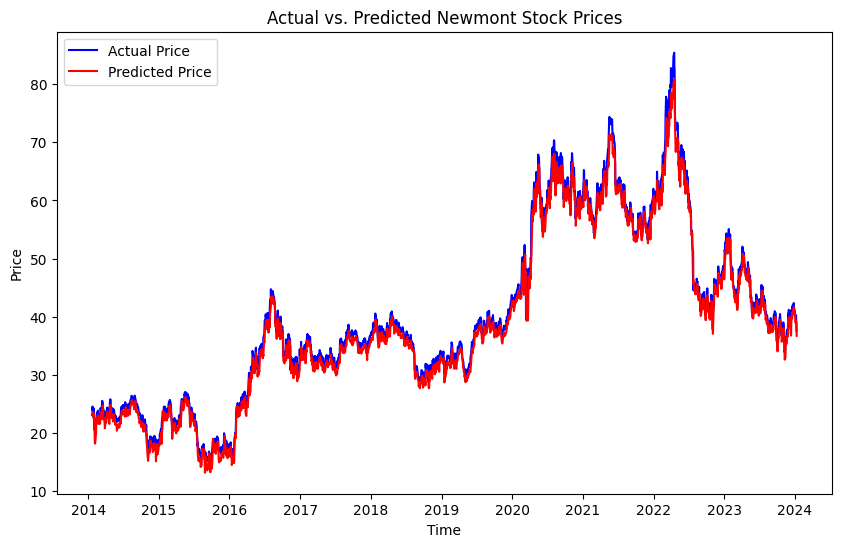

Mean Squared Error of True Data (RMSE): 2.4595210963344867
Mean Squared Error (RMSE): 0.000498376865908918


In [ ]:
# Plotting the actual vs. predicted newmont stock prices
plt.figure(figsize=(10, 6))
plt.plot(y_newmont_true, label='Actual Price', color='blue')
plt.plot(pred_newmont_GRU_true, label='Predicted Price', color='red')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Actual vs. Predicted Newmont Stock Prices')
plt.legend()
plt.show()

print("Mean Squared Error of True Data (RMSE):", mean_squared_error(y_newmont_true, pred_newmont_GRU_true))
print("Mean Squared Error (RMSE):", mean_squared_error(y_newmont, pred_newmont_GRU))

#### Oil

In [ ]:
#Oil

# Define the model
model_GRU_Oil = Sequential([
    GRU(32, activation = 'relu', return_sequences=True, input_shape=(window_size, len(features))),
    GRU(16, activation = 'relu', return_sequences=True),
    GRU(8, activation = 'relu', return_sequences=True),
    GRU(4,  activation = 'relu'),
    Dense(1)
])

# Compile the model
model_GRU_Oil.compile(optimizer='adam', loss='mse')

# Train the model
model_GRU_Oil.fit(X_train_oil, y_train_oil, epochs=50, batch_size=32, validation_split=0.2)

# Evaluate the model
loss_GRU_Oil_train = model_GRU_Oil.evaluate(X_train_oil, y_train_oil)
loss_GRU_Oil_test = model_GRU_Oil.evaluate(X_test_oil, y_test_oil)
print("Train Loss:", loss_GRU_Oil_train)
print("Test Loss:", loss_GRU_Oil_test)

#Predict
pred_oil_train_GRU = model_GRU_Oil.predict(X_train_oil)
pred_oil_train_GRU = pred_oil_train_GRU.reshape(len(pred_oil_train_GRU))

pred_oil_test_GRU = model_GRU_Oil.predict(X_test_oil)
pred_oil_test_GRU = pred_oil_test_GRU.reshape(len(pred_oil_test_GRU))

Epoch 1/50
63/63 [==============================] - 7s 32ms/step - loss: 0.0726 - val_loss: 0.0076
Epoch 2/50
63/63 [==============================] - 1s 22ms/step - loss: 0.0028 - val_loss: 0.0015
Epoch 3/50
63/63 [==============================] - 1s 21ms/step - loss: 2.7075e-04 - val_loss: 5.1375e-04
Epoch 4/50
63/63 [==============================] - 1s 21ms/step - loss: 1.5846e-04 - val_loss: 5.1563e-04
Epoch 5/50
63/63 [==============================] - 1s 21ms/step - loss: 1.6459e-04 - val_loss: 5.2355e-04
Epoch 6/50
63/63 [==============================] - 1s 21ms/step - loss: 1.6146e-04 - val_loss: 5.2346e-04
Epoch 7/50
63/63 [==============================] - 1s 21ms/step - loss: 1.5728e-04 - val_loss: 5.1424e-04
Epoch 8/50
63/63 [==============================] - 1s 21ms/step - loss: 1.5974e-04 - val_loss: 5.1754e-04
Epoch 9/50
63/63 [==============================] - 1s 21ms/step - loss: 1.5990e-04 - val_loss: 5.1995e-04
Epoch 10/50
63/63 [==============================] - 

#### Predict Oil Stock Price

In [ ]:
# Create the predictions
pred_chevron_GRU = model_GRU_Oil.predict(X_chevron)
pred_chevron_GRU = pred_chevron_GRU.reshape(len(pred_chevron_GRU))

pred_chevron_GRU_true = pd.DataFrame(inverse_minmax_scaling(pred_chevron_GRU, min(daily_chevron['Price']), max(daily_chevron['Price'])))

pred_chevron_GRU_true.set_index(y_chevron_true.index, inplace = True)

# Create the predictions
pred_exxon_GRU = model_GRU_Oil.predict(X_exxon)
pred_exxon_GRU = pred_exxon_GRU.reshape(len(pred_exxon_GRU))

pred_exxon_GRU_true = pd.DataFrame(inverse_minmax_scaling(pred_exxon_GRU, min(daily_exxon['Price']), max(daily_exxon['Price'])))

pred_exxon_GRU_true.set_index(y_exxon_true.index, inplace = True)

79/79 [==============================] - 0s 5ms/step


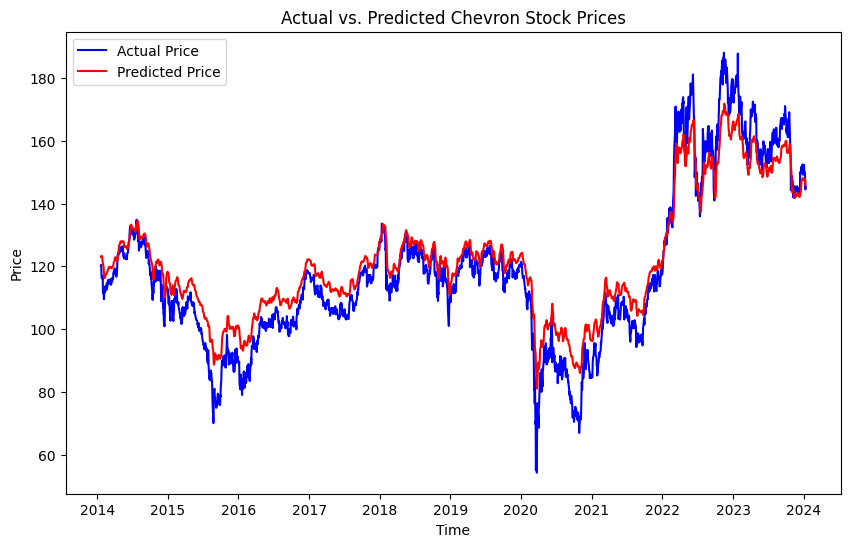

Mean Squared Error of True Data (RMSE): 57.84307466007116
Mean Squared Error of Scaled Data (RMSE): 0.0032295672339243994


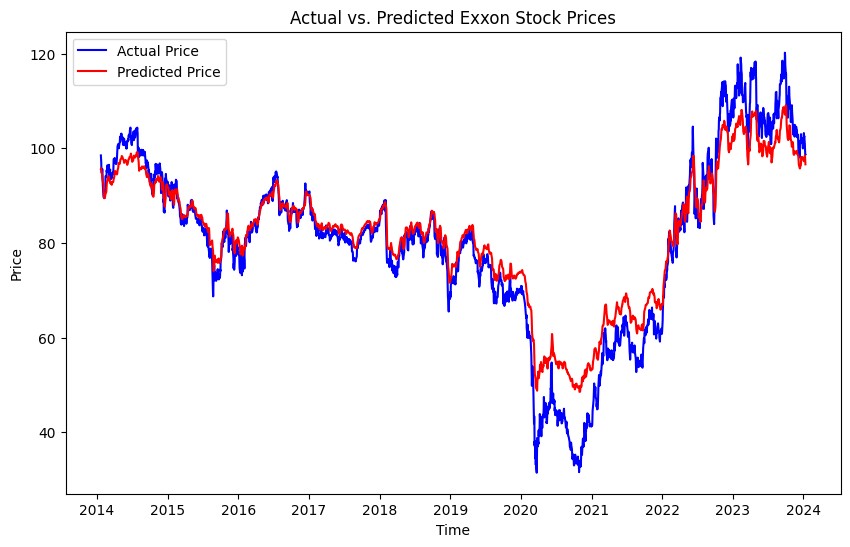

Mean Squared Error of True Data (RMSE): 28.649438638117704
Mean Squared Error of Scaled Data (RMSE): 0.0036373019070364337


In [ ]:
# Plotting the actual vs. predicted chevron stock prices
plt.figure(figsize=(10, 6))
plt.plot(y_chevron_true, label='Actual Price', color='blue')
plt.plot(pred_chevron_GRU_true, label='Predicted Price', color='red')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Actual vs. Predicted Chevron Stock Prices')
plt.legend()
plt.show()

print("Mean Squared Error of True Data (RMSE):", mean_squared_error(y_chevron_true, pred_chevron_GRU_true))
print("Mean Squared Error of Scaled Data (RMSE):", mean_squared_error(y_chevron, pred_chevron_GRU))

# Plotting the actual vs. predicted exxon stock prices
plt.figure(figsize=(10, 6))
plt.plot(y_exxon_true, label='Actual Price', color='blue')
plt.plot(pred_exxon_GRU_true, label='Predicted Price', color='red')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Actual vs. Predicted Exxon Stock Prices')
plt.legend()
plt.show()

print("Mean Squared Error of True Data (RMSE):", mean_squared_error(y_exxon_true, pred_exxon_GRU_true))
print("Mean Squared Error of Scaled Data (RMSE):", mean_squared_error(y_exxon, pred_exxon_GRU))

### Test 3 More Layers 128 > 64 > 32 > 16 > 8

In [ ]:
# Define the model
model_GRU_Gold = Sequential([
    GRU(128, activation = 'relu', return_sequences=True, input_shape=(window_size, len(features))),
    GRU(64, activation = 'relu', return_sequences=True),
    GRU(32, activation = 'relu', return_sequences=True),
    GRU(16, activation = 'relu', return_sequences=True),
    GRU(8, activation = 'relu'),
    Dense(1)
])

# Compile the model
model_GRU_Gold.compile(optimizer='adam', loss='mse')

# Train the model
model_GRU_Gold.fit(X_train_gold, y_train_gold, epochs=50, batch_size=32, validation_split=0.2)

# Evaluate the model
loss_GRU_Gold_train = model_GRU_Gold.evaluate(X_train_gold, y_train_gold)
loss_GRU_Gold_test = model_GRU_Gold.evaluate(X_test_gold, y_test_gold)
print("Train Loss:", loss_GRU_Gold_train)
print("Test Loss:", loss_GRU_Gold_test)

#Predict
pred_gold_train_GRU = model_GRU_Gold.predict(X_train_gold)
pred_gold_train_GRU = pred_gold_train_GRU.reshape(len(pred_gold_train_GRU))

pred_gold_test_GRU = model_GRU_Gold.predict(X_test_gold)
pred_gold_test_GRU = pred_gold_test_GRU.reshape(len(pred_gold_test_GRU))

Epoch 1/50
52/52 [==============================] - 5s 34ms/step - loss: 0.0227 - val_loss: 0.0160
Epoch 2/50
52/52 [==============================] - 1s 22ms/step - loss: 0.0016 - val_loss: 0.0097
Epoch 3/50
52/52 [==============================] - 1s 22ms/step - loss: 4.6899e-04 - val_loss: 0.0062
Epoch 4/50
52/52 [==============================] - 1s 22ms/step - loss: 4.3488e-04 - val_loss: 0.0015
Epoch 5/50
52/52 [==============================] - 1s 22ms/step - loss: 4.2744e-04 - val_loss: 0.0011
Epoch 6/50
52/52 [==============================] - 1s 22ms/step - loss: 3.5105e-04 - val_loss: 0.0013
Epoch 7/50
52/52 [==============================] - 1s 22ms/step - loss: 3.5962e-04 - val_loss: 0.0012
Epoch 8/50
52/52 [==============================] - 1s 22ms/step - loss: 3.2473e-04 - val_loss: 0.0012
Epoch 9/50
52/52 [==============================] - 1s 22ms/step - loss: 3.0140e-04 - val_loss: 0.0035
Epoch 10/50
52/52 [==============================] - 1s 23ms/step - loss: 2.8967e

#### Predict Gold StockPrice

In [ ]:
# Create the predictions Barrick
pred_barrick_GRU = model_GRU_Gold.predict(X_barrick)
pred_barrick_GRU = pred_barrick_GRU.reshape(len(pred_barrick_GRU))

pred_barrick_GRU_true = pd.DataFrame(inverse_minmax_scaling(pred_barrick_GRU, min(daily_barrick['Price']), max(daily_barrick['Price'])))

pred_barrick_GRU_true.set_index(y_barrick_true.index, inplace = True)

# Create the predictions Newmont
pred_newmont_GRU = model_GRU_Gold.predict(X_newmont)
pred_newmont_GRU = pred_newmont_GRU.reshape(len(pred_newmont_GRU))

pred_newmont_GRU_true = pd.DataFrame(inverse_minmax_scaling(pred_newmont_GRU, min(daily_newmont['Price']), max(daily_newmont['Price'])))

pred_newmont_GRU_true.set_index(y_newmont_true.index, inplace = True)

79/79 [==============================] - 1s 7ms/step


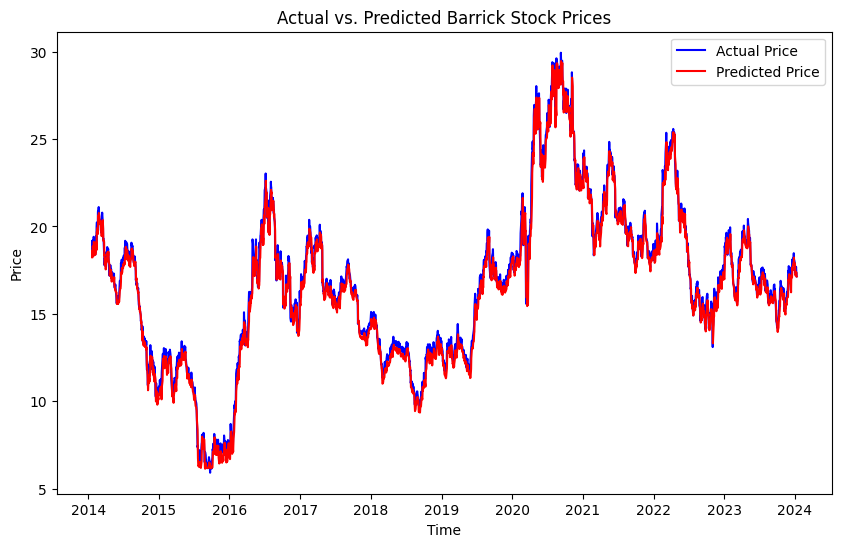

Mean Squared Error of True Data (RMSE): 0.2741178152191677
Mean Squared Error of Scaled Data(RMSE): 0.00047471161581858217


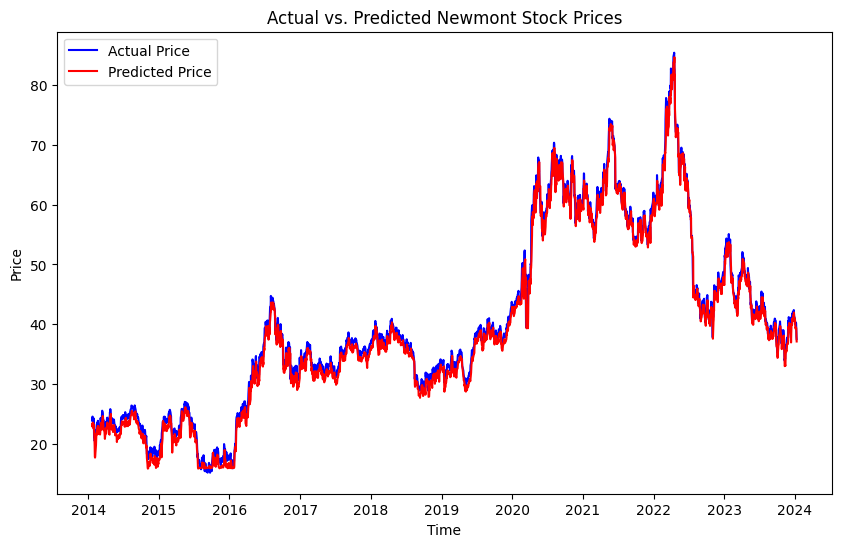

Mean Squared Error of True Data (RMSE): 1.839776267390111
Mean Squared Error (RMSE): 0.00037279697424491396


In [ ]:
# Plotting the actual vs. predicted barrick stock prices
plt.figure(figsize=(10, 6))
plt.plot(y_barrick_true, label='Actual Price', color='blue')
plt.plot(pred_barrick_GRU_true, label='Predicted Price', color='red')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Actual vs. Predicted Barrick Stock Prices')
plt.legend()
plt.show()

print("Mean Squared Error of True Data (RMSE):", mean_squared_error(y_barrick_true, pred_barrick_GRU_true))
print("Mean Squared Error of Scaled Data(RMSE):", mean_squared_error(y_barrick, pred_barrick_GRU))

# Plotting the actual vs. predicted newmont stock prices
plt.figure(figsize=(10, 6))
plt.plot(y_newmont_true, label='Actual Price', color='blue')
plt.plot(pred_newmont_GRU_true, label='Predicted Price', color='red')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Actual vs. Predicted Newmont Stock Prices')
plt.legend()
plt.show()

print("Mean Squared Error of True Data (RMSE):", mean_squared_error(y_newmont_true, pred_newmont_GRU_true))
print("Mean Squared Error (RMSE):", mean_squared_error(y_newmont, pred_newmont_GRU))

#### Oil

In [ ]:
#Oil

# Define the model
model_GRU_Oil = Sequential([
    GRU(128, activation = 'relu', return_sequences=True, input_shape=(window_size, len(features))),
    GRU(64, activation = 'relu', return_sequences=True),
    GRU(32, activation = 'relu', return_sequences=True),
    GRU(16, activation = 'relu', return_sequences=True),
    GRU(8,  activation = 'relu'),
    Dense(1)
])

# Compile the model
model_GRU_Oil.compile(optimizer='adam', loss='mse')

# Train the model
model_GRU_Oil.fit(X_train_oil, y_train_oil, epochs=50, batch_size=32, validation_split=0.2)

# Evaluate the model
loss_GRU_Oil_train = model_GRU_Oil.evaluate(X_train_oil, y_train_oil)
loss_GRU_Oil_test = model_GRU_Oil.evaluate(X_test_oil, y_test_oil)
print("Train Loss:", loss_GRU_Oil_train)
print("Test Loss:", loss_GRU_Oil_test)

#Predict
pred_oil_train_GRU = model_GRU_Oil.predict(X_train_oil)
pred_oil_train_GRU = pred_oil_train_GRU.reshape(len(pred_oil_train_GRU))

pred_oil_test_GRU = model_GRU_Oil.predict(X_test_oil)
pred_oil_test_GRU = pred_oil_test_GRU.reshape(len(pred_oil_test_GRU))

Epoch 1/50
63/63 [==============================] - 8s 45ms/step - loss: 0.1034 - val_loss: 0.0035
Epoch 2/50
63/63 [==============================] - 2s 34ms/step - loss: 0.0022 - val_loss: 0.0015
Epoch 3/50
63/63 [==============================] - 2s 32ms/step - loss: 2.6420e-04 - val_loss: 7.6670e-04
Epoch 4/50
63/63 [==============================] - 2s 32ms/step - loss: 2.0370e-04 - val_loss: 7.4406e-04
Epoch 5/50
63/63 [==============================] - 2s 32ms/step - loss: 2.1032e-04 - val_loss: 7.2158e-04
Epoch 6/50
63/63 [==============================] - 2s 32ms/step - loss: 2.0536e-04 - val_loss: 7.0709e-04
Epoch 7/50
63/63 [==============================] - 2s 33ms/step - loss: 1.9974e-04 - val_loss: 6.8574e-04
Epoch 8/50
63/63 [==============================] - 2s 33ms/step - loss: 2.0061e-04 - val_loss: 6.8479e-04
Epoch 9/50
63/63 [==============================] - 2s 33ms/step - loss: 2.0033e-04 - val_loss: 6.6735e-04
Epoch 10/50
63/63 [==============================] - 

#### Predict Oil Stock Price

In [ ]:
# Create the predictions
pred_chevron_GRU = model_GRU_Oil.predict(X_chevron)
pred_chevron_GRU = pred_chevron_GRU.reshape(len(pred_chevron_GRU))

pred_chevron_GRU_true = pd.DataFrame(inverse_minmax_scaling(pred_chevron_GRU, min(daily_chevron['Price']), max(daily_chevron['Price'])))

pred_chevron_GRU_true.set_index(y_chevron_true.index, inplace = True)

# Create the predictions
pred_exxon_GRU = model_GRU_Oil.predict(X_exxon)
pred_exxon_GRU = pred_exxon_GRU.reshape(len(pred_exxon_GRU))

pred_exxon_GRU_true = pd.DataFrame(inverse_minmax_scaling(pred_exxon_GRU, min(daily_exxon['Price']), max(daily_exxon['Price'])))

pred_exxon_GRU_true.set_index(y_exxon_true.index, inplace = True)

79/79 [==============================] - 1s 7ms/step


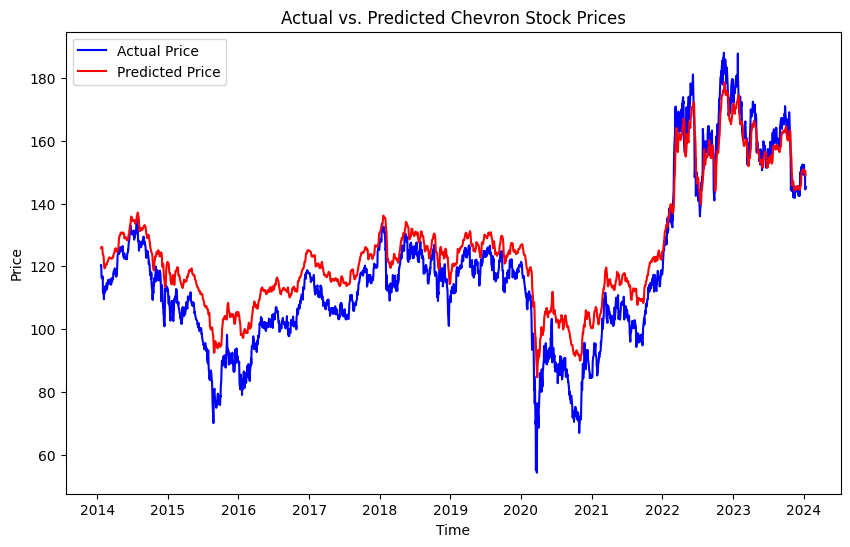

Mean Squared Error of True Data (RMSE): 94.72382998967745
Mean Squared Error of Scaled Data (RMSE): 0.005288739325567931


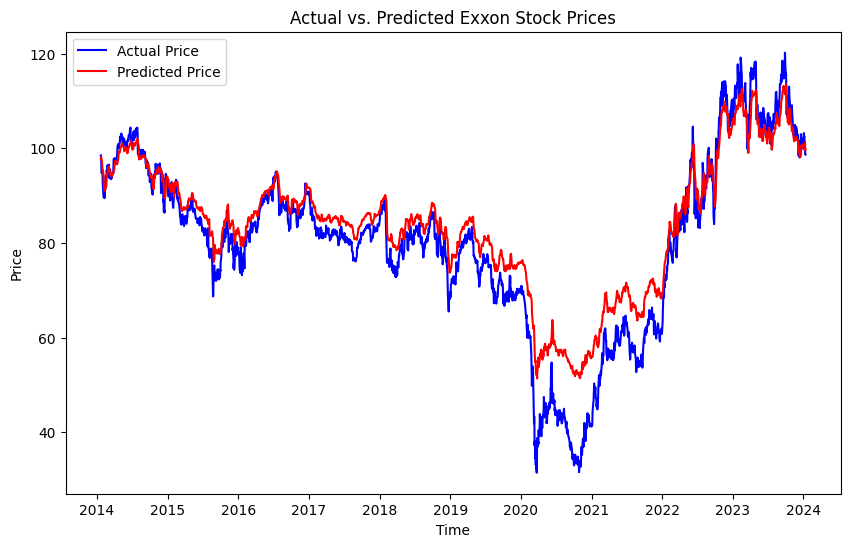

Mean Squared Error of True Data (RMSE): 40.030216206021734
Mean Squared Error of Scaled Data (RMSE): 0.005082192911671452


In [ ]:
# Plotting the actual vs. predicted chevron stock prices
plt.figure(figsize=(10, 6))
plt.plot(y_chevron_true, label='Actual Price', color='blue')
plt.plot(pred_chevron_GRU_true, label='Predicted Price', color='red')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Actual vs. Predicted Chevron Stock Prices')
plt.legend()
plt.show()

print("Mean Squared Error of True Data (RMSE):", mean_squared_error(y_chevron_true, pred_chevron_GRU_true))
print("Mean Squared Error of Scaled Data (RMSE):", mean_squared_error(y_chevron, pred_chevron_GRU))

# Plotting the actual vs. predicted exxon stock prices
plt.figure(figsize=(10, 6))
plt.plot(y_exxon_true, label='Actual Price', color='blue')
plt.plot(pred_exxon_GRU_true, label='Predicted Price', color='red')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Actual vs. Predicted Exxon Stock Prices')
plt.legend()
plt.show()

print("Mean Squared Error of True Data (RMSE):", mean_squared_error(y_exxon_true, pred_exxon_GRU_true))
print("Mean Squared Error of Scaled Data (RMSE):", mean_squared_error(y_exxon, pred_exxon_GRU))

### Test 4 Less Layers 128 > 32 > 8

In [ ]:
# Define the model
model_GRU_Gold = Sequential([
    GRU(128, activation = 'relu', return_sequences=True, input_shape=(window_size, len(features))),
    GRU(32, activation = 'relu', return_sequences=True),
    GRU(8, activation = 'relu'),
    Dense(1)
])

# Compile the model
model_GRU_Gold.compile(optimizer='adam', loss='mse')

# Train the model
model_GRU_Gold.fit(X_train_gold, y_train_gold, epochs=50, batch_size=32, validation_split=0.2)

# Evaluate the model
loss_GRU_Gold_train = model_GRU_Gold.evaluate(X_train_gold, y_train_gold)
loss_GRU_Gold_test = model_GRU_Gold.evaluate(X_test_gold, y_test_gold)
print("Train Loss:", loss_GRU_Gold_train)
print("Test Loss:", loss_GRU_Gold_test)

#Predict
pred_gold_train_GRU = model_GRU_Gold.predict(X_train_gold)
pred_gold_train_GRU = pred_gold_train_GRU.reshape(len(pred_gold_train_GRU))

pred_gold_test_GRU = model_GRU_Gold.predict(X_test_gold)
pred_gold_test_GRU = pred_gold_test_GRU.reshape(len(pred_gold_test_GRU))

Epoch 1/50
52/52 [==============================] - 3s 23ms/step - loss: 0.0089 - val_loss: 0.0041
Epoch 2/50
52/52 [==============================] - 1s 15ms/step - loss: 4.1530e-04 - val_loss: 0.0012
Epoch 3/50
52/52 [==============================] - 1s 16ms/step - loss: 3.4019e-04 - val_loss: 7.2650e-04
Epoch 4/50
52/52 [==============================] - 1s 16ms/step - loss: 3.4388e-04 - val_loss: 6.6816e-04
Epoch 5/50
52/52 [==============================] - 1s 16ms/step - loss: 2.8114e-04 - val_loss: 6.1875e-04
Epoch 6/50
52/52 [==============================] - 1s 16ms/step - loss: 2.6315e-04 - val_loss: 0.0012
Epoch 7/50
52/52 [==============================] - 1s 16ms/step - loss: 2.9099e-04 - val_loss: 6.4956e-04
Epoch 8/50
52/52 [==============================] - 1s 15ms/step - loss: 2.3193e-04 - val_loss: 5.4034e-04
Epoch 9/50
52/52 [==============================] - 1s 16ms/step - loss: 2.1508e-04 - val_loss: 0.0019
Epoch 10/50
52/52 [==============================] - 1s 1

#### Predict Gold Stock Price

In [ ]:
# Create the predictions Barrick
pred_barrick_GRU = model_GRU_Gold.predict(X_barrick)
pred_barrick_GRU = pred_barrick_GRU.reshape(len(pred_barrick_GRU))

pred_barrick_GRU_true = pd.DataFrame(inverse_minmax_scaling(pred_barrick_GRU, min(daily_barrick['Price']), max(daily_barrick['Price'])))

pred_barrick_GRU_true.set_index(y_barrick_true.index, inplace = True)

# Create the predictions Newmont
pred_newmont_GRU = model_GRU_Gold.predict(X_newmont)
pred_newmont_GRU = pred_newmont_GRU.reshape(len(pred_newmont_GRU))

pred_newmont_GRU_true = pd.DataFrame(inverse_minmax_scaling(pred_newmont_GRU, min(daily_newmont['Price']), max(daily_newmont['Price'])))

pred_newmont_GRU_true.set_index(y_newmont_true.index, inplace = True)

79/79 [==============================] - 0s 5ms/step


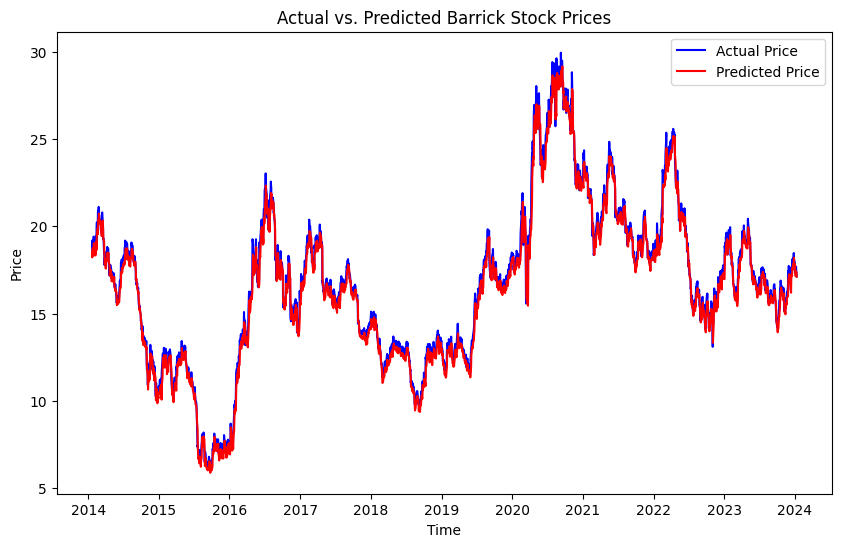

Mean Squared Error of True Data (RMSE): 0.28181903293527893
Mean Squared Error of Scaled Data(RMSE): 0.00048804840729766124


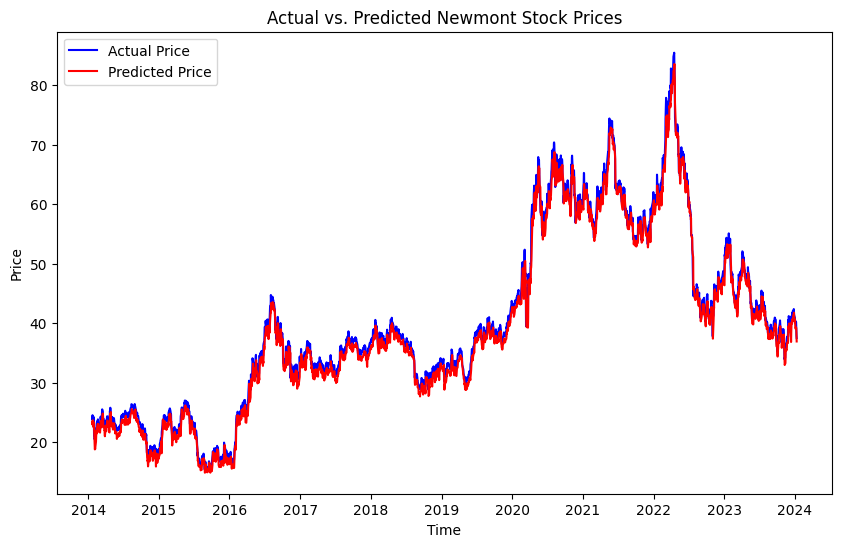

Mean Squared Error of True Data (RMSE): 1.9371682568011181
Mean Squared Error (RMSE): 0.0003925317042270159


In [ ]:
# Plotting the actual vs. predicted barrick stock prices
plt.figure(figsize=(10, 6))
plt.plot(y_barrick_true, label='Actual Price', color='blue')
plt.plot(pred_barrick_GRU_true, label='Predicted Price', color='red')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Actual vs. Predicted Barrick Stock Prices')
plt.legend()
plt.show()

print("Mean Squared Error of True Data (RMSE):", mean_squared_error(y_barrick_true, pred_barrick_GRU_true))
print("Mean Squared Error of Scaled Data(RMSE):", mean_squared_error(y_barrick, pred_barrick_GRU))

# Plotting the actual vs. predicted newmont stock prices
plt.figure(figsize=(10, 6))
plt.plot(y_newmont_true, label='Actual Price', color='blue')
plt.plot(pred_newmont_GRU_true, label='Predicted Price', color='red')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Actual vs. Predicted Newmont Stock Prices')
plt.legend()
plt.show()

print("Mean Squared Error of True Data (RMSE):", mean_squared_error(y_newmont_true, pred_newmont_GRU_true))
print("Mean Squared Error (RMSE):", mean_squared_error(y_newmont, pred_newmont_GRU))

#### Oil

In [ ]:
#Oil

# Define the model
model_GRU_Oil = Sequential([
    GRU(128, activation = 'relu', return_sequences=True, input_shape=(window_size, len(features))),
    GRU(32, activation = 'relu', return_sequences=True),
    GRU(8,  activation = 'relu'),
    Dense(1)
])

# Compile the model
model_GRU_Oil.compile(optimizer='adam', loss='mse')

# Train the model
model_GRU_Oil.fit(X_train_oil, y_train_oil, epochs=50, batch_size=32, validation_split=0.2)

# Evaluate the model
loss_GRU_Oil_train = model_GRU_Oil.evaluate(X_train_oil, y_train_oil)
loss_GRU_Oil_test = model_GRU_Oil.evaluate(X_test_oil, y_test_oil)
print("Train Loss:", loss_GRU_Oil_train)
print("Test Loss:", loss_GRU_Oil_test)

#Predict
pred_oil_train_GRU = model_GRU_Oil.predict(X_train_oil)
pred_oil_train_GRU = pred_oil_train_GRU.reshape(len(pred_oil_train_GRU))

pred_oil_test_GRU = model_GRU_Oil.predict(X_test_oil)
pred_oil_test_GRU = pred_oil_test_GRU.reshape(len(pred_oil_test_GRU))

Epoch 1/50
63/63 [==============================] - 6s 30ms/step - loss: 0.0833 - val_loss: 0.0068
Epoch 2/50
63/63 [==============================] - 1s 21ms/step - loss: 0.0018 - val_loss: 8.3779e-04
Epoch 3/50
63/63 [==============================] - 1s 21ms/step - loss: 1.7171e-04 - val_loss: 6.0259e-04
Epoch 4/50
63/63 [==============================] - 1s 22ms/step - loss: 1.6009e-04 - val_loss: 5.8478e-04
Epoch 5/50
63/63 [==============================] - 1s 22ms/step - loss: 1.6541e-04 - val_loss: 5.7534e-04
Epoch 6/50
63/63 [==============================] - 1s 22ms/step - loss: 1.5848e-04 - val_loss: 5.6194e-04
Epoch 7/50
63/63 [==============================] - 1s 22ms/step - loss: 1.5356e-04 - val_loss: 5.2407e-04
Epoch 8/50
63/63 [==============================] - 1s 23ms/step - loss: 1.5551e-04 - val_loss: 5.2593e-04
Epoch 9/50
63/63 [==============================] - 1s 21ms/step - loss: 1.5564e-04 - val_loss: 5.3451e-04
Epoch 10/50
63/63 [==============================

In [ ]:
# Create the predictions
pred_chevron_GRU = model_GRU_Oil.predict(X_chevron)
pred_chevron_GRU = pred_chevron_GRU.reshape(len(pred_chevron_GRU))

pred_chevron_GRU_true = pd.DataFrame(inverse_minmax_scaling(pred_chevron_GRU, min(daily_chevron['Price']), max(daily_chevron['Price'])))

pred_chevron_GRU_true.set_index(y_chevron_true.index, inplace = True)

# Create the predictions
pred_exxon_GRU = model_GRU_Oil.predict(X_exxon)
pred_exxon_GRU = pred_exxon_GRU.reshape(len(pred_exxon_GRU))

pred_exxon_GRU_true = pd.DataFrame(inverse_minmax_scaling(pred_exxon_GRU, min(daily_exxon['Price']), max(daily_exxon['Price'])))

pred_exxon_GRU_true.set_index(y_exxon_true.index, inplace = True)

79/79 [==============================] - 0s 4ms/step


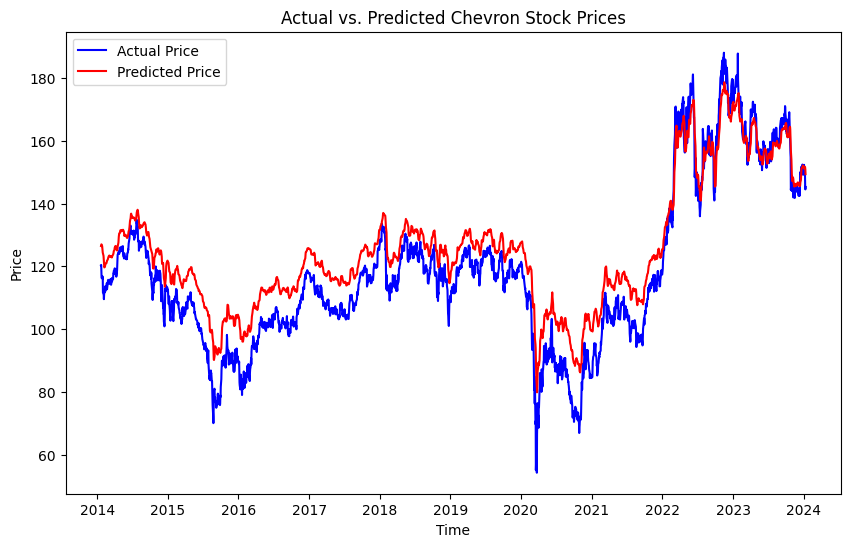

Mean Squared Error of True Data (RMSE): 89.94172894914742
Mean Squared Error of Scaled Data (RMSE): 0.005021738996966723


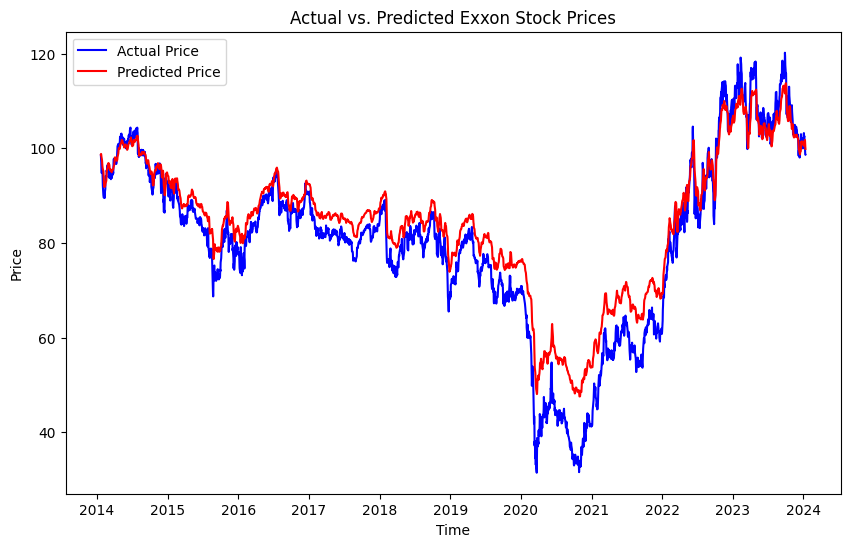

Mean Squared Error of True Data (RMSE): 35.15614126635929
Mean Squared Error of Scaled Data (RMSE): 0.0044633855366465825


In [ ]:
# Plotting the actual vs. predicted chevron stock prices
plt.figure(figsize=(10, 6))
plt.plot(y_chevron_true, label='Actual Price', color='blue')
plt.plot(pred_chevron_GRU_true, label='Predicted Price', color='red')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Actual vs. Predicted Chevron Stock Prices')
plt.legend()
plt.show()

print("Mean Squared Error of True Data (RMSE):", mean_squared_error(y_chevron_true, pred_chevron_GRU_true))
print("Mean Squared Error of Scaled Data (RMSE):", mean_squared_error(y_chevron, pred_chevron_GRU))

# Plotting the actual vs. predicted exxon stock prices
plt.figure(figsize=(10, 6))
plt.plot(y_exxon_true, label='Actual Price', color='blue')
plt.plot(pred_exxon_GRU_true, label='Predicted Price', color='red')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Actual vs. Predicted Exxon Stock Prices')
plt.legend()
plt.show()

print("Mean Squared Error of True Data (RMSE):", mean_squared_error(y_exxon_true, pred_exxon_GRU_true))
print("Mean Squared Error of Scaled Data (RMSE):", mean_squared_error(y_exxon, pred_exxon_GRU))

### Test 5 Same Neurons 32 > 32 > 32 > 32

In [ ]:
# Define the model
model_GRU_Gold = Sequential([
    GRU(32, activation = 'relu', return_sequences=True, input_shape=(window_size, len(features))),
    GRU(32, activation = 'relu', return_sequences=True),
    GRU(32, activation = 'relu', return_sequences=True),
    GRU(32, activation = 'relu'),
    Dense(1)
])

# Compile the model
model_GRU_Gold.compile(optimizer='adam', loss='mse')

# Train the model
model_GRU_Gold.fit(X_train_gold, y_train_gold, epochs=50, batch_size=32, validation_split=0.2)

# Evaluate the model
loss_GRU_Gold_train = model_GRU_Gold.evaluate(X_train_gold, y_train_gold)
loss_GRU_Gold_test = model_GRU_Gold.evaluate(X_test_gold, y_test_gold)
print("Train Loss:", loss_GRU_Gold_train)
print("Test Loss:", loss_GRU_Gold_test)

#Predict
pred_gold_train_GRU = model_GRU_Gold.predict(X_train_gold)
pred_gold_train_GRU = pred_gold_train_GRU.reshape(len(pred_gold_train_GRU))

pred_gold_test_GRU = model_GRU_Gold.predict(X_test_gold)
pred_gold_test_GRU = pred_gold_test_GRU.reshape(len(pred_gold_test_GRU))

Epoch 1/50
52/52 [==============================] - 4s 25ms/step - loss: 0.0214 - val_loss: 0.0524
Epoch 2/50
52/52 [==============================] - 1s 15ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 3/50
52/52 [==============================] - 1s 15ms/step - loss: 3.8297e-04 - val_loss: 8.6685e-04
Epoch 4/50
52/52 [==============================] - 1s 14ms/step - loss: 3.5983e-04 - val_loss: 0.0013
Epoch 5/50
52/52 [==============================] - 1s 14ms/step - loss: 3.1711e-04 - val_loss: 6.5192e-04
Epoch 6/50
52/52 [==============================] - 1s 15ms/step - loss: 2.8075e-04 - val_loss: 0.0014
Epoch 7/50
52/52 [==============================] - 1s 14ms/step - loss: 3.3889e-04 - val_loss: 5.6877e-04
Epoch 8/50
52/52 [==============================] - 1s 14ms/step - loss: 2.5041e-04 - val_loss: 8.2087e-04
Epoch 9/50
52/52 [==============================] - 1s 15ms/step - loss: 2.3791e-04 - val_loss: 0.0012
Epoch 10/50
52/52 [==============================] - 1s 14ms/step

#### Predict Gold Stock Price

In [ ]:
# Create the predictions Barrick
pred_barrick_GRU = model_GRU_Gold.predict(X_barrick)
pred_barrick_GRU = pred_barrick_GRU.reshape(len(pred_barrick_GRU))

pred_barrick_GRU_true = pd.DataFrame(inverse_minmax_scaling(pred_barrick_GRU, min(daily_barrick['Price']), max(daily_barrick['Price'])))

pred_barrick_GRU_true.set_index(y_barrick_true.index, inplace = True)

# Create the predictions Newmont
pred_newmont_GRU = model_GRU_Gold.predict(X_newmont)
pred_newmont_GRU = pred_newmont_GRU.reshape(len(pred_newmont_GRU))

pred_newmont_GRU_true = pd.DataFrame(inverse_minmax_scaling(pred_newmont_GRU, min(daily_newmont['Price']), max(daily_newmont['Price'])))

pred_newmont_GRU_true.set_index(y_newmont_true.index, inplace = True)

79/79 [==============================] - 0s 6ms/step


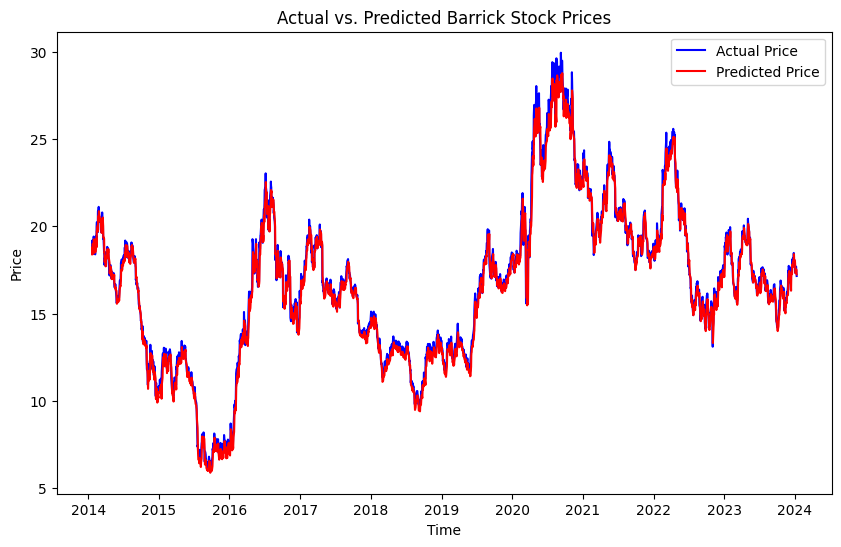

Mean Squared Error of True Data (RMSE): 0.25514201095519534
Mean Squared Error of Scaled Data(RMSE): 0.00044184967327453537


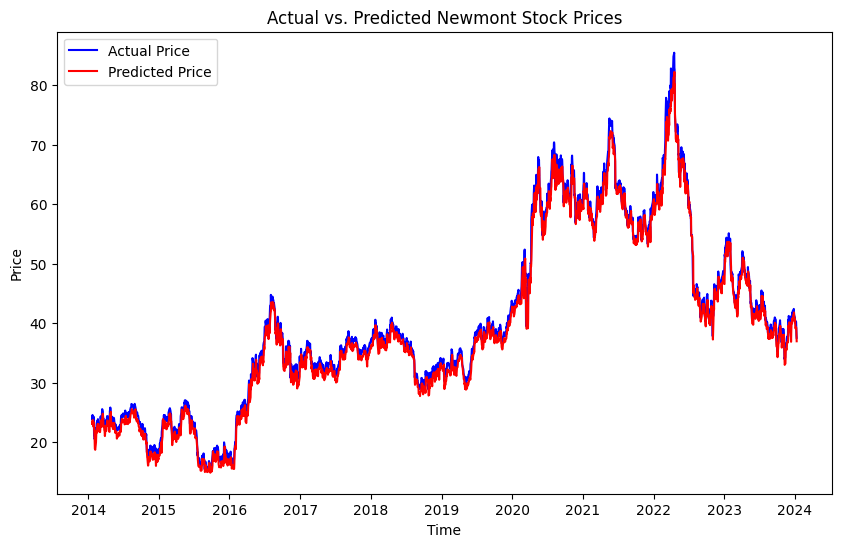

Mean Squared Error of True Data (RMSE): 1.989932140025829
Mean Squared Error (RMSE): 0.0004032233260783548


In [ ]:
# Plotting the actual vs. predicted barrick stock prices
plt.figure(figsize=(10, 6))
plt.plot(y_barrick_true, label='Actual Price', color='blue')
plt.plot(pred_barrick_GRU_true, label='Predicted Price', color='red')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Actual vs. Predicted Barrick Stock Prices')
plt.legend()
plt.show()

print("Mean Squared Error of True Data (RMSE):", mean_squared_error(y_barrick_true, pred_barrick_GRU_true))
print("Mean Squared Error of Scaled Data(RMSE):", mean_squared_error(y_barrick, pred_barrick_GRU))

# Plotting the actual vs. predicted newmont stock prices
plt.figure(figsize=(10, 6))
plt.plot(y_newmont_true, label='Actual Price', color='blue')
plt.plot(pred_newmont_GRU_true, label='Predicted Price', color='red')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Actual vs. Predicted Newmont Stock Prices')
plt.legend()
plt.show()

print("Mean Squared Error of True Data (RMSE):", mean_squared_error(y_newmont_true, pred_newmont_GRU_true))
print("Mean Squared Error (RMSE):", mean_squared_error(y_newmont, pred_newmont_GRU))

#### Oil

In [ ]:
#Oil

# Define the model
model_GRU_Oil = Sequential([
    GRU(32, activation = 'relu', return_sequences=True, input_shape=(window_size, len(features))),
    GRU(32, activation = 'relu', return_sequences=True),
    GRU(32, activation = 'relu', return_sequences=True),
    GRU(32,  activation = 'relu'),
    Dense(1)
])

# Compile the model
model_GRU_Oil.compile(optimizer='adam', loss='mse')

# Train the model
model_GRU_Oil.fit(X_train_oil, y_train_oil, epochs=50, batch_size=32, validation_split=0.2)

# Evaluate the model
loss_GRU_Oil_train = model_GRU_Oil.evaluate(X_train_oil, y_train_oil)
loss_GRU_Oil_test = model_GRU_Oil.evaluate(X_test_oil, y_test_oil)
print("Train Loss:", loss_GRU_Oil_train)
print("Test Loss:", loss_GRU_Oil_test)

#Predict
pred_oil_train_GRU = model_GRU_Oil.predict(X_train_oil)
pred_oil_train_GRU = pred_oil_train_GRU.reshape(len(pred_oil_train_GRU))

pred_oil_test_GRU = model_GRU_Oil.predict(X_test_oil)
pred_oil_test_GRU = pred_oil_test_GRU.reshape(len(pred_oil_test_GRU))

Epoch 1/50
63/63 [==============================] - 6s 32ms/step - loss: 0.1038 - val_loss: 0.0096
Epoch 2/50
63/63 [==============================] - 1s 23ms/step - loss: 0.0031 - val_loss: 0.0030
Epoch 3/50
63/63 [==============================] - 1s 23ms/step - loss: 6.4838e-04 - val_loss: 8.6060e-04
Epoch 4/50
63/63 [==============================] - 1s 23ms/step - loss: 1.8652e-04 - val_loss: 6.9667e-04
Epoch 5/50
63/63 [==============================] - 1s 23ms/step - loss: 1.8979e-04 - val_loss: 6.9035e-04
Epoch 6/50
63/63 [==============================] - 1s 22ms/step - loss: 1.8069e-04 - val_loss: 6.7108e-04
Epoch 7/50
63/63 [==============================] - 1s 23ms/step - loss: 1.7384e-04 - val_loss: 6.4371e-04
Epoch 8/50
63/63 [==============================] - 1s 23ms/step - loss: 1.7329e-04 - val_loss: 6.3405e-04
Epoch 9/50
63/63 [==============================] - 1s 23ms/step - loss: 1.7308e-04 - val_loss: 6.3524e-04
Epoch 10/50
63/63 [==============================] - 

#### Predict Oil Stock Price

In [ ]:
# Create the predictions
pred_chevron_GRU = model_GRU_Oil.predict(X_chevron)
pred_chevron_GRU = pred_chevron_GRU.reshape(len(pred_chevron_GRU))

pred_chevron_GRU_true = pd.DataFrame(inverse_minmax_scaling(pred_chevron_GRU, min(daily_chevron['Price']), max(daily_chevron['Price'])))

pred_chevron_GRU_true.set_index(y_chevron_true.index, inplace = True)

# Create the predictions
pred_exxon_GRU = model_GRU_Oil.predict(X_exxon)
pred_exxon_GRU = pred_exxon_GRU.reshape(len(pred_exxon_GRU))

pred_exxon_GRU_true = pd.DataFrame(inverse_minmax_scaling(pred_exxon_GRU, min(daily_exxon['Price']), max(daily_exxon['Price'])))

pred_exxon_GRU_true.set_index(y_exxon_true.index, inplace = True)

79/79 [==============================] - 0s 5ms/step


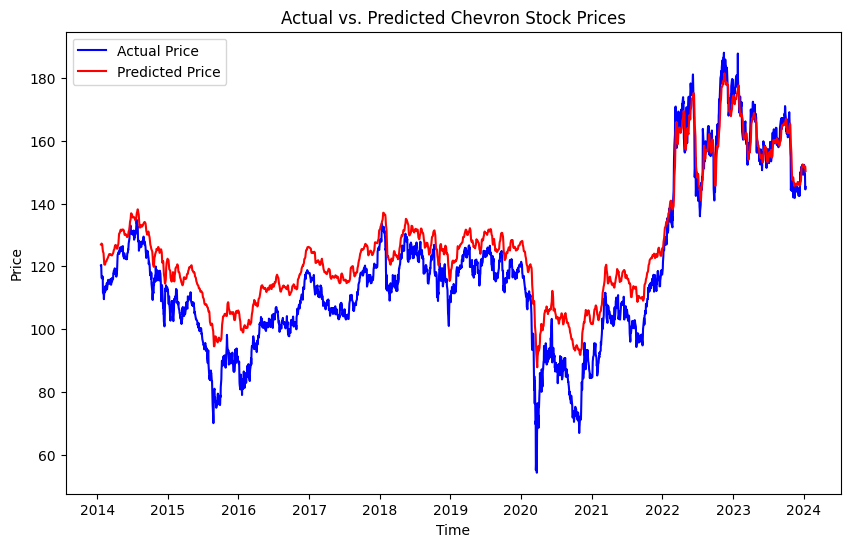

Mean Squared Error of True Data (RMSE): 108.97871809575538
Mean Squared Error of Scaled Data (RMSE): 0.006084635920313524


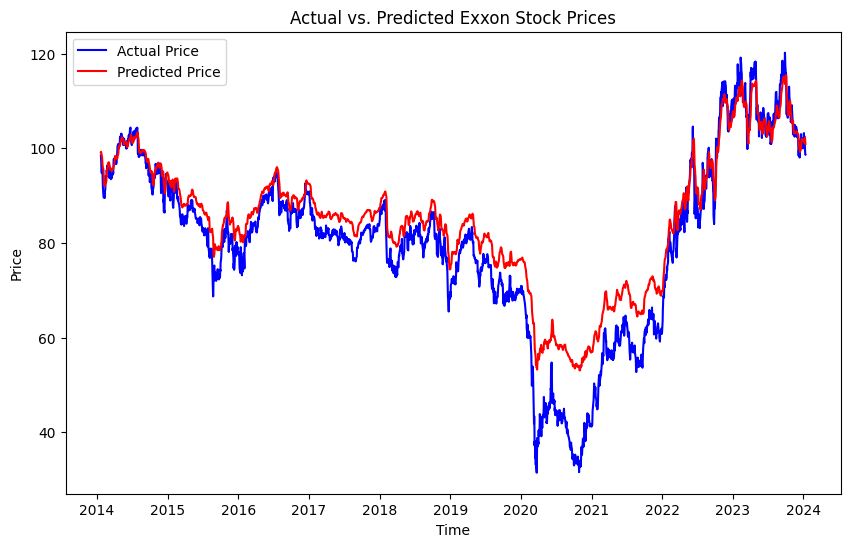

Mean Squared Error of True Data (RMSE): 46.23708677867367
Mean Squared Error of Scaled Data (RMSE): 0.00587021049198665


In [ ]:
# Plotting the actual vs. predicted chevron stock prices
plt.figure(figsize=(10, 6))
plt.plot(y_chevron_true, label='Actual Price', color='blue')
plt.plot(pred_chevron_GRU_true, label='Predicted Price', color='red')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Actual vs. Predicted Chevron Stock Prices')
plt.legend()
plt.show()

print("Mean Squared Error of True Data (RMSE):", mean_squared_error(y_chevron_true, pred_chevron_GRU_true))
print("Mean Squared Error of Scaled Data (RMSE):", mean_squared_error(y_chevron, pred_chevron_GRU))

# Plotting the actual vs. predicted exxon stock prices
plt.figure(figsize=(10, 6))
plt.plot(y_exxon_true, label='Actual Price', color='blue')
plt.plot(pred_exxon_GRU_true, label='Predicted Price', color='red')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Actual vs. Predicted Exxon Stock Prices')
plt.legend()
plt.show()

print("Mean Squared Error of True Data (RMSE):", mean_squared_error(y_exxon_true, pred_exxon_GRU_true))
print("Mean Squared Error of Scaled Data (RMSE):", mean_squared_error(y_exxon, pred_exxon_GRU))

### Test 6 Same Neurons 128 > 128 > 128 > 128

In [ ]:
# Define the model
model_GRU_Gold = Sequential([
    GRU(128, activation = 'relu', return_sequences=True, input_shape=(window_size, len(features))),
    GRU(128, activation = 'relu', return_sequences=True),
    GRU(128, activation = 'relu', return_sequences=True),
    GRU(128, activation = 'relu'),
    Dense(1)
])

# Compile the model
model_GRU_Gold.compile(optimizer='adam', loss='mse')

# Train the model
model_GRU_Gold.fit(X_train_gold, y_train_gold, epochs=50, batch_size=32, validation_split=0.2)

# Evaluate the model
loss_GRU_Gold_train = model_GRU_Gold.evaluate(X_train_gold, y_train_gold)
loss_GRU_Gold_test = model_GRU_Gold.evaluate(X_test_gold, y_test_gold)
print("Train Loss:", loss_GRU_Gold_train)
print("Test Loss:", loss_GRU_Gold_test)

#Predict
pred_gold_train_GRU = model_GRU_Gold.predict(X_train_gold)
pred_gold_train_GRU = pred_gold_train_GRU.reshape(len(pred_gold_train_GRU))

pred_gold_test_GRU = model_GRU_Gold.predict(X_test_gold)
pred_gold_test_GRU = pred_gold_test_GRU.reshape(len(pred_gold_test_GRU))

Epoch 1/50
52/52 [==============================] - 5s 57ms/step - loss: 0.0101 - val_loss: 0.0100
Epoch 2/50
52/52 [==============================] - 2s 37ms/step - loss: 6.0138e-04 - val_loss: 0.0011
Epoch 3/50
52/52 [==============================] - 2s 36ms/step - loss: 4.8034e-04 - val_loss: 0.0010
Epoch 4/50
52/52 [==============================] - 2s 37ms/step - loss: 4.7041e-04 - val_loss: 0.0011
Epoch 5/50
52/52 [==============================] - 2s 37ms/step - loss: 4.0479e-04 - val_loss: 0.0017
Epoch 6/50
52/52 [==============================] - 2s 37ms/step - loss: 3.9894e-04 - val_loss: 0.0015
Epoch 7/50
52/52 [==============================] - 2s 37ms/step - loss: 4.8042e-04 - val_loss: 0.0013
Epoch 8/50
52/52 [==============================] - 2s 37ms/step - loss: 3.3872e-04 - val_loss: 7.4770e-04
Epoch 9/50
52/52 [==============================] - 2s 36ms/step - loss: 3.0987e-04 - val_loss: 0.0033
Epoch 10/50
52/52 [==============================] - 2s 36ms/step - loss:

#### Predict Gold Stock Price

In [ ]:
# Create the predictions Barrick
pred_barrick_GRU = model_GRU_Gold.predict(X_barrick)
pred_barrick_GRU = pred_barrick_GRU.reshape(len(pred_barrick_GRU))

pred_barrick_GRU_true = pd.DataFrame(inverse_minmax_scaling(pred_barrick_GRU, min(daily_barrick['Price']), max(daily_barrick['Price'])))

pred_barrick_GRU_true.set_index(y_barrick_true.index, inplace = True)

# Create the predictions Newmont
pred_newmont_GRU = model_GRU_Gold.predict(X_newmont)
pred_newmont_GRU = pred_newmont_GRU.reshape(len(pred_newmont_GRU))

pred_newmont_GRU_true = pd.DataFrame(inverse_minmax_scaling(pred_newmont_GRU, min(daily_newmont['Price']), max(daily_newmont['Price'])))

pred_newmont_GRU_true.set_index(y_newmont_true.index, inplace = True)

79/79 [==============================] - 1s 7ms/step


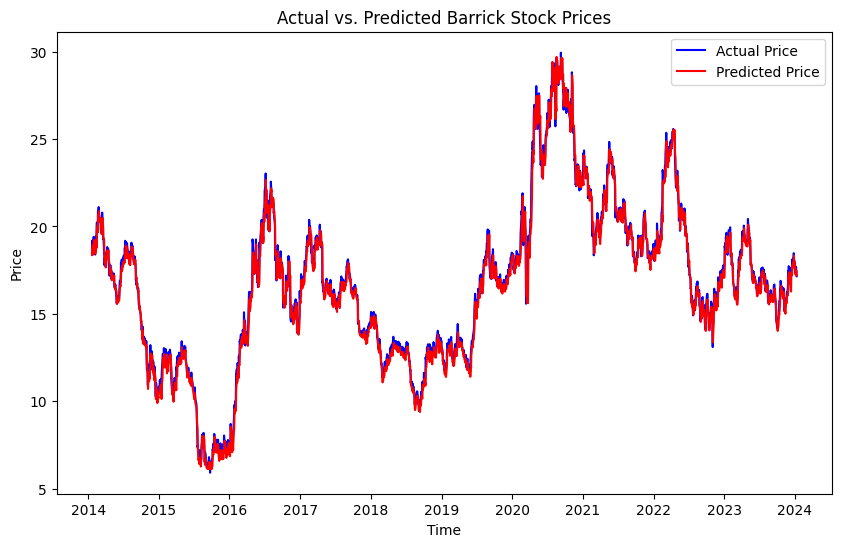

Mean Squared Error of True Data (RMSE): 0.22783319894616
Mean Squared Error of Scaled Data(RMSE): 0.0003945567853174888


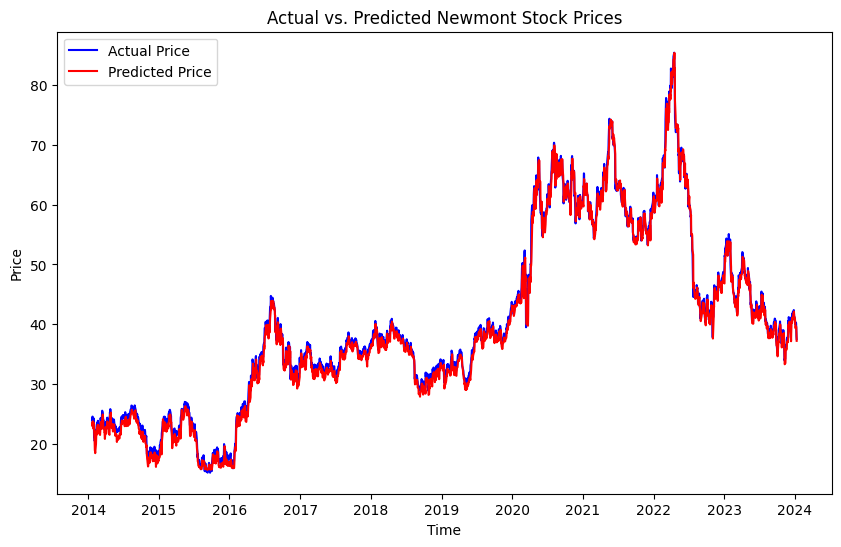

Mean Squared Error of True Data (RMSE): 1.4133415444273936
Mean Squared Error (RMSE): 0.0002863878023806473


In [ ]:
# Plotting the actual vs. predicted barrick stock prices
plt.figure(figsize=(10, 6))
plt.plot(y_barrick_true, label='Actual Price', color='blue')
plt.plot(pred_barrick_GRU_true, label='Predicted Price', color='red')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Actual vs. Predicted Barrick Stock Prices')
plt.legend()
plt.show()

print("Mean Squared Error of True Data (RMSE):", mean_squared_error(y_barrick_true, pred_barrick_GRU_true))
print("Mean Squared Error of Scaled Data(RMSE):", mean_squared_error(y_barrick, pred_barrick_GRU))

# Plotting the actual vs. predicted newmont stock prices
plt.figure(figsize=(10, 6))
plt.plot(y_newmont_true, label='Actual Price', color='blue')
plt.plot(pred_newmont_GRU_true, label='Predicted Price', color='red')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Actual vs. Predicted Newmont Stock Prices')
plt.legend()
plt.show()

print("Mean Squared Error of True Data (RMSE):", mean_squared_error(y_newmont_true, pred_newmont_GRU_true))
print("Mean Squared Error (RMSE):", mean_squared_error(y_newmont, pred_newmont_GRU))

#### Oil

In [ ]:
#Oil

# Define the model
model_GRU_Oil = Sequential([
    GRU(128, activation = 'relu', return_sequences=True, input_shape=(window_size, len(features))),
    GRU(128, activation = 'relu', return_sequences=True),
    GRU(128, activation = 'relu', return_sequences=True),
    GRU(128,  activation = 'relu'),
    Dense(1)
])

# Compile the model
model_GRU_Oil.compile(optimizer='adam', loss='mse')

# Train the model
model_GRU_Oil.fit(X_train_oil, y_train_oil, epochs=50, batch_size=32, validation_split=0.2)

# Evaluate the model
loss_GRU_Oil_train = model_GRU_Oil.evaluate(X_train_oil, y_train_oil)
loss_GRU_Oil_test = model_GRU_Oil.evaluate(X_test_oil, y_test_oil)
print("Train Loss:", loss_GRU_Oil_train)
print("Test Loss:", loss_GRU_Oil_test)

#Predict
pred_oil_train_GRU = model_GRU_Oil.predict(X_train_oil)
pred_oil_train_GRU = pred_oil_train_GRU.reshape(len(pred_oil_train_GRU))

pred_oil_test_GRU = model_GRU_Oil.predict(X_test_oil)
pred_oil_test_GRU = pred_oil_test_GRU.reshape(len(pred_oil_test_GRU))

Epoch 1/50
63/63 [==============================] - 7s 53ms/step - loss: 0.0508 - val_loss: 0.0025
Epoch 2/50
63/63 [==============================] - 3s 45ms/step - loss: 7.3212e-04 - val_loss: 6.9750e-04
Epoch 3/50
63/63 [==============================] - 3s 46ms/step - loss: 1.8563e-04 - val_loss: 6.9903e-04
Epoch 4/50
63/63 [==============================] - 3s 45ms/step - loss: 1.8300e-04 - val_loss: 6.5709e-04
Epoch 5/50
63/63 [==============================] - 3s 45ms/step - loss: 1.8491e-04 - val_loss: 6.2719e-04
Epoch 6/50
63/63 [==============================] - 3s 43ms/step - loss: 1.8045e-04 - val_loss: 6.3492e-04
Epoch 7/50
63/63 [==============================] - 3s 45ms/step - loss: 1.8534e-04 - val_loss: 5.9594e-04
Epoch 8/50
63/63 [==============================] - 3s 46ms/step - loss: 1.7797e-04 - val_loss: 5.9506e-04
Epoch 9/50
63/63 [==============================] - 3s 48ms/step - loss: 1.8730e-04 - val_loss: 5.8699e-04
Epoch 10/50
63/63 [==========================

#### Predict Oil Stock PRice

In [ ]:
# Create the predictions
pred_chevron_GRU = model_GRU_Oil.predict(X_chevron)
pred_chevron_GRU = pred_chevron_GRU.reshape(len(pred_chevron_GRU))

pred_chevron_GRU_true = pd.DataFrame(inverse_minmax_scaling(pred_chevron_GRU, min(daily_chevron['Price']), max(daily_chevron['Price'])))

pred_chevron_GRU_true.set_index(y_chevron_true.index, inplace = True)

# Create the predictions
pred_exxon_GRU = model_GRU_Oil.predict(X_exxon)
pred_exxon_GRU = pred_exxon_GRU.reshape(len(pred_exxon_GRU))

pred_exxon_GRU_true = pd.DataFrame(inverse_minmax_scaling(pred_exxon_GRU, min(daily_exxon['Price']), max(daily_exxon['Price'])))

pred_exxon_GRU_true.set_index(y_exxon_true.index, inplace = True)

79/79 [==============================] - 1s 7ms/step


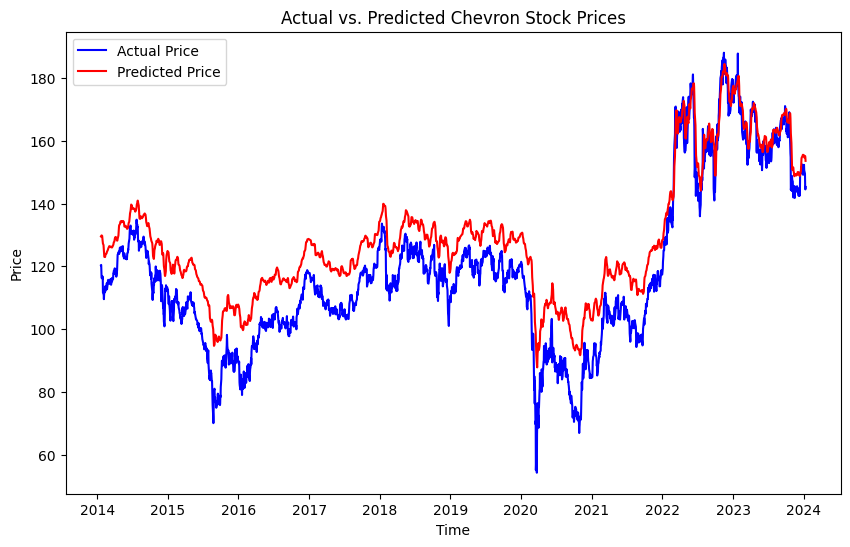

Mean Squared Error of True Data (RMSE): 149.3856966189004
Mean Squared Error of Scaled Data (RMSE): 0.00834068886858303


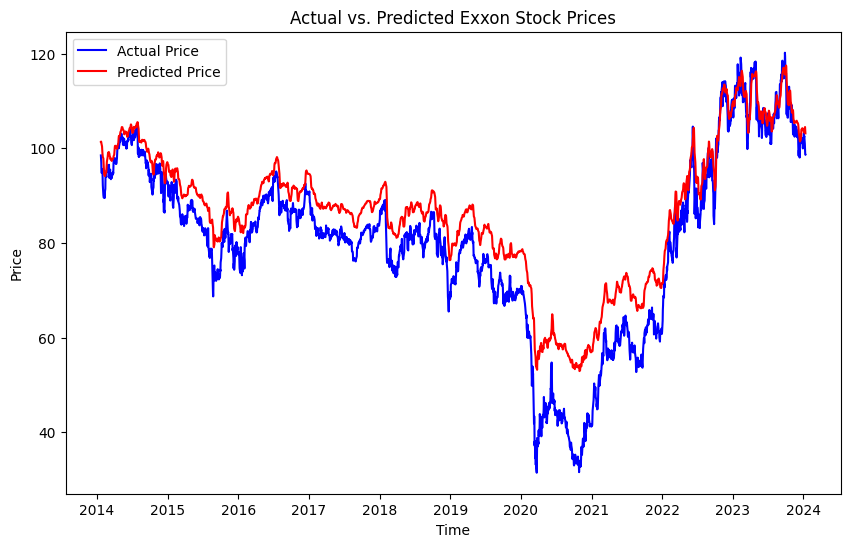

Mean Squared Error of True Data (RMSE): 61.59957157807808
Mean Squared Error of Scaled Data (RMSE): 0.00782061487242739


In [ ]:
# Plotting the actual vs. predicted chevron stock prices
plt.figure(figsize=(10, 6))
plt.plot(y_chevron_true, label='Actual Price', color='blue')
plt.plot(pred_chevron_GRU_true, label='Predicted Price', color='red')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Actual vs. Predicted Chevron Stock Prices')
plt.legend()
plt.show()

print("Mean Squared Error of True Data (RMSE):", mean_squared_error(y_chevron_true, pred_chevron_GRU_true))
print("Mean Squared Error of Scaled Data (RMSE):", mean_squared_error(y_chevron, pred_chevron_GRU))

# Plotting the actual vs. predicted exxon stock prices
plt.figure(figsize=(10, 6))
plt.plot(y_exxon_true, label='Actual Price', color='blue')
plt.plot(pred_exxon_GRU_true, label='Predicted Price', color='red')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Actual vs. Predicted Exxon Stock Prices')
plt.legend()
plt.show()

print("Mean Squared Error of True Data (RMSE):", mean_squared_error(y_exxon_true, pred_exxon_GRU_true))
print("Mean Squared Error of Scaled Data (RMSE):", mean_squared_error(y_exxon, pred_exxon_GRU))

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=37cc49da-a460-4de1-b51b-4428efcf8114' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>